Introduction for Psychologists:

Hello. This is a demo of our model on predicting depression risk and explaining with features and cases. It is trained on a data set of cases.

**Case**: a survey participant who answered 102 questions of depression screening survey (self-reporting). Each participant has a depression risk score 0,1,2 (judged by a psychologist, based on number of depression-related physical symptoms)

**Feature**: Answers to survey questions (yes/no)

**Query**: the new client who we are making a prediction on.

**How does it work:**
 Our model learns about important features and cases during training. Given a new query (a new client), our model makes a prediction by retrieving the most relevant cases. It can explain in two main ways: highlighting (non-)important features, or highlighting (non-)important cases.

**Goal**: The Goal of this demo is not to show you how good or how bad our model performs but more to open up a discussion about what you feel about using such models (part 2 of the interview). Please ignore the non-existing User-experience (UI) and the software code aspects because it is just a prototype. I will do my best to show you only the relevant parts.

# 1 Setup

On google colab, you have to restart runtime after running the following line

In [1]:
!pip install omegaconf

In [2]:
from google.colab import drive
drive.mount("/content/drive/")
#"/content/drive/My Drive/NN-kNN/"

# For Ye
# folder_name = "/content/drive/Othercomputers/My MacBook Pro/GitHub/NN-kNN/"

#For everyone else
#Once you add this folder's shortcut to your google drive, it would work
folder_name = "/content/drive/MyDrive/NN-kNN/"

import sys
sys.path.insert(0,folder_name)

Mounted at /content/drive/


In [3]:
##This is added because my Rdata uses Cdata for the covid data set.
##Rdata use Cdata function to load the data set, then convert it to regression problem
import os
import sys
sys.path.append(folder_name + 'dataset')


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from omegaconf import DictConfig, OmegaConf

from dataset import cls_small_data as Cdata
import model.cls_model as Cmodel
from dataset import cls_medium_data

from dataset import reg_data as Rdata
import model.reg_model as Rmodel

In [5]:
conf_file = OmegaConf.load(os.path.join(folder_name, 'config.yaml'))

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
torch.cuda.is_available()

True

In [8]:
random_seed = 43

In [9]:
debug_print = False
def dprint(*args):
  global debug_print
  if debug_print:
    print(*args)

# NCA and LMNN setup

In [ ]:
pip install metric-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 1.9 MB/s eta 0:00:00


In [ ]:
import metric_learn
from metric_learn import LMNN,NCA

# 2 Data Sets

Supported small dataset for classification:  
'zebra',
'zebra_special',
'bal',
'digits',
'iris',
'wine',
'breast_cancer',

for regression:
'califonia_housing',
'abalone',
'diabets',
'body_fat',
'ziweifaces'


Newly added data sets for mental health (psychology):

Classification:
'psych_depression_physical_symptons',
'covid_anxious',
'covid_depressed'


In [10]:
dataset_name = 'cifar10'
cfg = conf_file['dataset'][dataset_name]
if dataset_name in ['covid_anxious','covid_depressed','covid_physical','covid_lonely','covid_hopeless',
                    'psych_depression_physical_symptons',
                    'zebra','zebra_special','bal','digits','iris','wine','breast_cancer']:
    criterion = torch.nn.CrossEntropyLoss()
    Xs, ys = Cdata.Cls_small_data(dataset_name, folder_name)
elif dataset_name in ['mnist','cifar10','svhn','SST1','SST2']:
    criterion = torch.nn.CrossEntropyLoss()
    X_train, y_train, X_test, y_test = cls_medium_data.Cls_medium_data(dataset_name)

    # if dataset_name == 'mnist':
    #     X_train, y_train, X_test, y_test = cls_medium_data.Cls_medium_data(dataset_name)
    # else:
    #     X_train, y_train, X_test, y_test, classes = cls_medium_data.Cls_medium_data(dataset_name)
elif dataset_name in ['sst1', 'sst2']:
    train_data, val_data, test_data = cls_medium_data.Cls_medium_data(dataset_name)
else:
    criterion = torch.nn.MSELoss()
    Xs, ys = Rdata.Reg_data(dataset_name)

100%|██████████| 170M/170M [00:11<00:00, 14.7MB/s]


Extracting ./dataset/cifar-10-python.tar.gz to ./dataset/
Files already downloaded and verified
Computed Mean: 0.4733630120754242, Computed Std: 0.21108365058898926
Files already downloaded and verified
Files already downloaded and verified


In [158]:
num_samples = Xs.shape[0]
num_features = Xs.shape[1]
num_classes = len(np.unique(ys))

print("Dataset Characteristics:")
print(f"Number of samples: {num_samples}")
print(f"Number of features: {num_features}")
print(f"Number of classes: {num_classes}")

Dataset Characteristics:
Number of samples: 73257
Number of features: 3
Number of classes: 10


OR use below for given partition

In [ ]:
num_samples_train = X_train.shape[0]
num_features = X_train.shape[1]
num_classes = len(np.unique(y_train))
print("Train Dataset Characteristics (Training Set):")
print(f"Number of samples: {num_samples_train}")
print(f"Number of features: {num_features}")
print(f"Number of classes: {num_classes}")

num_samples_test = X_test.shape[0]
print("Test Dataset Characteristics (Test Set):")
print(f"Number of samples: {num_samples_test}")

Train Dataset Characteristics (Training Set):
Number of samples: 50000
Number of features: 3
Number of classes: 10
Test Dataset Characteristics (Test Set):
Number of samples: 10000


In [ ]:
# prompt: print out data set characteristics, number of features, number of samples, number of classes

import numpy as np

# Assuming Xs and ys are defined as in the provided code (replace with actual data if different)
if dataset_name in ['covid_anxious','covid_depressed','covid_physical','covid_lonely','covid_hopeless',
                    'psych_depression_physical_symptons',
                    'zebra','zebra_special','bal','digits','iris','wine','breast_cancer']:
    Xs, ys = Cdata.Cls_small_data(dataset_name, folder_name)  # Replace with your actual data loading
    num_samples = Xs.shape[0]
    num_features = Xs.shape[1]
    num_classes = len(np.unique(ys))

    print("Dataset Characteristics:")
    print(f"Number of samples: {num_samples}")
    print(f"Number of features: {num_features}")
    print(f"Number of classes: {num_classes}")
elif dataset_name in ['mnist','cifar10']:
    # Access data from X_train, y_train, X_test, y_test
    num_samples_train = X_train.shape[0]
    num_features = X_train.shape[1]
    num_classes = len(np.unique(y_train))
    print("Dataset Characteristics (Training Set):")
    print(f"Number of samples: {num_samples_train}")
    print(f"Number of features: {num_features}")
    print(f"Number of classes: {num_classes}")
else:
    Xs, ys = Rdata.Reg_data(dataset_name)
    num_samples = Xs.shape[0]
    num_features = Xs.shape[1]
    # Regression doesn't have classes in the same sense
    print("Dataset Characteristics:")
    print(f"Number of samples: {num_samples}")
    print(f"Number of features: {num_features}")
    print("This is a regression dataset, no distinct classes.")

Dataset Characteristics (Training Set):
Number of samples: 50000
Number of features: 3
Number of classes: 10


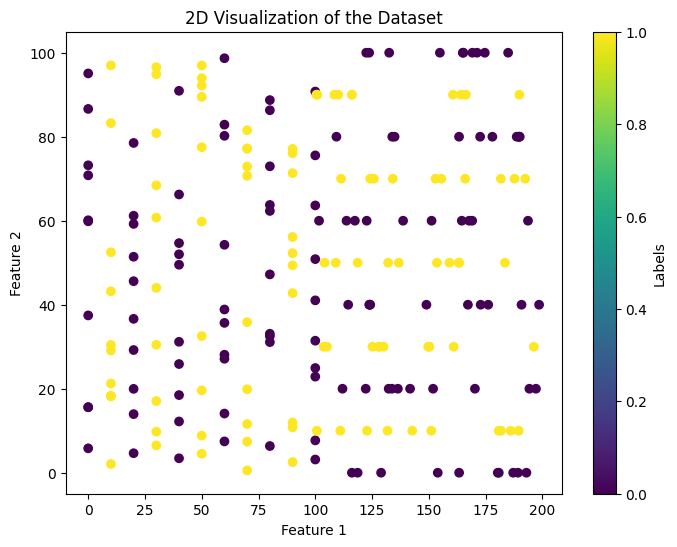

In [ ]:
# prompt: visualize the data set in a 2-d plot, the two dimension are the two features, color the labels

import matplotlib.pyplot as plt

# Assuming Xs is a numpy array or a list of lists where each inner list represents a data point with two features.
# Assuming ys is a numpy array or a list representing the labels for each data point.

# Check if Xs and ys are compatible
if len(Xs) != len(ys):
    raise ValueError("The number of data points in Xs and ys must be the same.")

# Extract the two features for plotting
feature1 = [x[0] for x in Xs]
feature2 = [x[1] for x in Xs]


# Create the 2D plot
plt.figure(figsize=(8, 6))
plt.scatter(feature1, feature2, c=ys, cmap='viridis') # Color the points based on labels
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("2D Visualization of the Dataset")
plt.colorbar(label="Labels") # Add a colorbar to show the mapping of colors to labels
plt.show()

In [ ]:
# for dataset "psych_depression_physical_symptons"
columns = ['1. Most of the time I have difficulty concentrating on simple tasks', "2. I don't feel like doing my daily duties", '3. My friends or family have told me that I look different', '4. When I think about the future it is difficult for me to imagine it clearly', '5. People around me often ask me how I feel', '6. I consider that my life is full of good things', '7. My hobbies are still important to me', "8. I'm still as punctual as I have always been", '9. If I had the chance, I would spend all day in my bed', '10. I have found that I can spend a lot of time scrolling the screen \nof my cell phone without searching or stopping at anything in particular', '11. When someone asks me something, I have noticed that I take longer than normal to\nrespond', '12. I have noticed my body shaken without any cause', '13. I felt more encouraged to do my daily activities before', "14. Sometimes I wake up sad and I can't explain why", '15. In recent months I usually reproach myself for things from the past', '16. I think my thoughts are strange or different from before', '17. I feel guilty about the decisions that I have made', "18. I don't feel as comfortable with my body as I did before", "19. I don't feel successful compared to others", '20. It is difficult for me to make decisions even if they are simple', "21. I'm capable of achieving what I propose to myself", '22. It is not difficult for me to understand something the first time', '23. I have thought more than before about what my death would be like', '24. Being dead seems to be a solution to some problems', '25. I would rather stay home than go out with my friends', '26. I like to attend family gatherings', '27. I feel excited when thinking about my life project', '28. The decisions I have made so far have been the right ones', '29. I am able to carry out my activities as I have always been', '30. I like to be in touch with my friends and family through social media', '31. It is easy for me to choose a photograph of myself to show it on social media', '32. I am proud of what I have achieved so far', '33. I have trouble remembering things easily', '34. In recent months I have had discussions with my schoolmates or colleagues', '35. I constantly imagine that something will go wrong at my work or at school', '36. I am afraid of being worng when doing my homework', "37. I'm not too worried about what might happen in a few weeks", "38. Lately it's hard for me to calm down", '39. Everything will be alright', '40. I can easily blank my mind', '41. I am bothered by insignificant things that were not important before', '42. I find it uncomfortable to be in a crowded place', '43. Sometimes i feel trapped', '44. I am easily frightened by unexpected noises', '45. I have difficulties to do one task at a time', '46. I have the feeling that I am forgetting to do something', '47. I can clearly express to others how I feel', '48. I can sleep easily', '49. I enjoy every moment of the day', '50. I imagine that at any moment a disaster of the\nnature may occur', '51. Sometimes I feel like I get tired easily', '52. Being locked in an elevator would be the worst thing that could happen to me', "53. I'm bothered by people walking slowly in front of me ", "54. I don't usually get upset if something doesn't go as expected", '55. Sometimes it is as if some conversations with friends or family become\ninterrogations', '56. I manage my schedule as I always have', '57. It bothers me to feel that people on the street approach me', '58. I have no difficulty understanding what people explain to me', '59. I consider that I am good at controlling my emotions', '60. In new situations I feel calm and encouraged', '61. Sometimes I forget what I wanted to say because I have several thoughts at the same time', '62. I would like to know what will happen in the future', '63. When I get angry I can easily explode', '64. I can put down my cell phone and dedicate myself to reading without distractions', '65. I worry that people will not understand what I mean.', '66. Sometimes I do not listen to what people say to me because I am thinking about other things', '67. I get angry easily', "68. I'm afraid that something bad could happen to me", '69. It is not important for me to meet set dates', '70. I like to think clearly before giving my opinion', '71. I use lies just to get out of certain problems', '72. If I have the opportunity to get in line to avoid wasting time, I do it', '73. I have difficulty making elaborate plans', '74. People have problems because of themselves', '75. No me parece importante lo que los otros piensen sobre mí', '76. Laws are not as important as others think', '77. I would regret betraying a friend', '78. I prefer that a negotiation supports the largest possible number of people involved', '79. It is easy for me to work in a team', '80. It is important to help people when they need it', '81. I have punched someone or thought of doing it', '82. If it was necessary I would pretend to be someone else to get something', '83. I consider it important to ensure my physical safety and that of those around me', '84. After an argument I usually go over what happened in my head', '85. I have a hard time controlling myself when I get angry', '86. Loyalty is important', "87. If I can help a person I will stop what I'm doing to help him", '88', '89. It makes me laugh when my superiors at school or at work demand something', '90. Deceiving people is not wrong if it is to achieve something important', '91. I like to greet my neighbors', '92. It does not seem serious to me to have some debts', '93. People steal because they have needs', '94. I lose control easily', "95. Neighbors must put up with each other's noises without complaining", '96. Littering on public roads is wrong', '97. People who commit crimes have their reasons for doing it', '98. It is normal to change jobs several times a year', '99. It is important to respect turns', '100. I could pretend to be someone else to achieve what I want', '101. I consider it important that all people have the same rights', '102. I have a hard time taking  "no" for an answer']

In [ ]:
columns

['1. Most of the time I have difficulty concentrating on simple tasks',
 "2. I don't feel like doing my daily duties",
 '3. My friends or family have told me that I look different',
 '4. When I think about the future it is difficult for me to imagine it clearly',
 '5. People around me often ask me how I feel',
 '6. I consider that my life is full of good things',
 '7. My hobbies are still important to me',
 "8. I'm still as punctual as I have always been",
 '9. If I had the chance, I would spend all day in my bed',
 '10. I have found that I can spend a lot of time scrolling the screen \nof my cell phone without searching or stopping at anything in particular',
 '11. When someone asks me something, I have noticed that I take longer than normal to\nrespond',
 '12. I have noticed my body shaken without any cause',
 '13. I felt more encouraged to do my daily activities before',
 "14. Sometimes I wake up sad and I can't explain why",
 '15. In recent months I usually reproach myself for thin

In [ ]:
columns[0]

'1. Most of the time I have difficulty concentrating on simple tasks'

In [ ]:
columns[101]

'102. I have a hard time taking  "no" for an answer'

In [ ]:
# This section is used to reload the imported module.
# For example, if you made any changes in the model.cls_model, you should run importlib.reload(Cmodel) as long as you set import model.cls_model as Cmodel.
import importlib
importlib.reload(Rdata)
importlib.reload(Cdata)
importlib.reload(cls_medium_data)

<module 'dataset.cls_medium_data' from '/content/drive/MyDrive/NN-kNN/dataset/cls_medium_data.py'>

In [ ]:
#for reloading config file, in case you modified it for experimenting
conf_file = OmegaConf.load(os.path.join(folder_name, 'config.yaml'))
cfg = conf_file['dataset'][dataset_name]

##SST

In [ ]:

dataset_name = "SST"
#dummy system, because training uses cfg somewhere and I am too lazy to change
cfg = conf_file['dataset']['cifar10']

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Version 1, 5 labels

In [ ]:
from datasets import load_dataset

# Load SST-1 dataset
dataset = load_dataset("sst", "default")

# Map continuous labels to discrete classes
def map_to_classes(example):
    if example['label'] < 0.2:
        example['label'] = 0  # Very Negative
    elif example['label'] < 0.4:
        example['label'] = 1  # Negative
    elif example['label'] < 0.6:
        example['label'] = 2  # Neutral
    elif example['label'] < 0.8:
        example['label'] = 3  # Positive
    else:
        example['label'] = 4  # Very Positive
    return example

# Apply mapping
dataset = dataset.map(map_to_classes)

# Access train, validation, and test splits
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

# Example: Print first training example
print(train_data[0])

{'sentence': "The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .", 'label': 3.0, 'tokens': "The|Rock|is|destined|to|be|the|21st|Century|'s|new|``|Conan|''|and|that|he|'s|going|to|make|a|splash|even|greater|than|Arnold|Schwarzenegger|,|Jean-Claud|Van|Damme|or|Steven|Segal|.", 'tree': '70|70|68|67|63|62|61|60|58|58|57|56|56|64|65|55|54|53|52|51|49|47|47|46|46|45|40|40|41|39|38|38|43|37|37|69|44|39|42|41|42|43|44|45|50|48|48|49|50|51|52|53|54|55|66|57|59|59|60|61|62|63|64|65|66|67|68|69|71|71|0'}


Version 2, 2 labels, take out neutral

In [ ]:
from datasets import load_dataset

# Load SST-1 dataset
dataset = load_dataset("sst", "default")

# Map continuous labels to binary classes: Negative (0, 1) and Positive (3, 4)
def map_to_binary_classes(example):
    if example['label'] < 0.4:  # Negative (Very Negative or Negative)
        example['label'] = 0  # Negative
    elif example['label'] >= 0.6:  # Positive (Positive or Very Positive)
        example['label'] = 1  # Positive
    else:
        return None  # Exclude Neutral (labels between 0.4 and 0.6)
    return example

# Apply mapping and remove neutral examples
dataset = dataset.filter(lambda example: example['label'] < 0.4 or example['label'] >= 0.6)
dataset = dataset.map(map_to_binary_classes)

# Access train, validation, and test splits
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

# Example: Print first training example
print(train_data[0])


Filter:   0%|          | 0/8544 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1101 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2210 [00:00<?, ? examples/s]

Map:   0%|          | 0/6920 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

{'sentence': "The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .", 'label': 1.0, 'tokens': "The|Rock|is|destined|to|be|the|21st|Century|'s|new|``|Conan|''|and|that|he|'s|going|to|make|a|splash|even|greater|than|Arnold|Schwarzenegger|,|Jean-Claud|Van|Damme|or|Steven|Segal|.", 'tree': '70|70|68|67|63|62|61|60|58|58|57|56|56|64|65|55|54|53|52|51|49|47|47|46|46|45|40|40|41|39|38|38|43|37|37|69|44|39|42|41|42|43|44|45|50|48|48|49|50|51|52|53|54|55|66|57|59|59|60|61|62|63|64|65|66|67|68|69|71|71|0'}


#GO

##Feature Extractor

### For MNIST

In [ ]:
# prompt: a classifier with conv layers for MNIST

import torch.nn as nn
import torch.nn.functional as F

class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Adjust input size based on image dimensions
        self.fc2 = nn.Linear(128, 10)  # Output size is 10 for 10 digits

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Example usage
model = MNISTClassifier()
model

MNISTClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### For Cifar10

https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

In [11]:
# prompt: a classifier with conv layers for cifar10

import torch
import torch.nn as nn
import torch.nn.functional as F

class CIFAR10Classifier(nn.Module):
    def __init__(self):
        super(CIFAR10Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # Adjust input size based on image dimensions and pooling
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8) # Adjust input size based on image dimensions and pooling
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Example usage
conv_model = CIFAR10Classifier()
# Dummy input (replace with your actual CIFAR-10 data)
dummy_input = torch.randn(1, 3, 32, 32)  # Batch size 1, 3 color channels, 32x32 image
output = conv_model(dummy_input)
output

NameError: name 'model' is not defined

### Get Feature Extractor from Model

In [13]:
def get_feature_extractor_from(model):
    ##WITHOUT INITIALIZATION
    feature_extractor = torch.nn.Sequential(
      model.conv1,
      nn.ReLU(),   # Add ReLU here
      model.pool,
      model.conv2,
      nn.ReLU(),   # Add ReLU here
      model.pool,
      torch.nn.Flatten(),
      model.fc1
    )
    feature_extractor.feature_dim = model.fc1.out_features
    feature_extractor.to(device)
    return feature_extractor

In [14]:
feature_extractor = get_feature_extractor_from(model)

###Re-initialize Feature Extractor

In [12]:
def iniitialize_feature_extractor():
    model = CIFAR10Classifier()
    feature_extractor = torch.nn.Sequential(
      model.conv1,
      nn.ReLU(),   # Add ReLU here
      model.pool,
      model.conv2,
      nn.ReLU(),   # Add ReLU here
      model.pool,
      torch.nn.Flatten(),
      model.fc1
    )
    feature_extractor.feature_dim = model.fc1.out_features
    feature_extractor.to(device)
    return feature_extractor


In [13]:
feature_extractor = iniitialize_feature_extractor()

In [14]:
feature_extractor.state_dict()

OrderedDict([('0.weight',
              tensor([[[[ 6.7165e-02,  1.4305e-01,  1.1360e-01],
                        [ 8.8112e-02,  4.0805e-02,  2.0901e-02],
                        [ 1.9366e-02, -1.1676e-01,  1.3327e-03]],
              
                       [[ 1.6622e-01, -1.8113e-01,  1.1591e-01],
                        [ 3.4203e-03, -1.2521e-01, -3.4239e-02],
                        [-8.8171e-03, -1.4451e-01,  4.2906e-02]],
              
                       [[ 2.1078e-02, -7.2027e-02, -7.4803e-02],
                        [-1.3378e-01,  5.3005e-02, -1.7690e-01],
                        [-4.3997e-02,  1.8184e-01,  1.2569e-01]]],
              
              
                      [[[-2.3191e-02, -1.1057e-01, -1.2380e-01],
                        [-1.7680e-01, -4.6601e-02, -4.7497e-02],
                        [ 1.9075e-01, -1.0580e-01, -1.3451e-01]],
              
                       [[ 1.6612e-01,  3.5456e-02,  1.4542e-01],
                        [-1.6923e-01, -7.8988e-02

If you don't want feature extractor


In [ ]:
feature_extractor = None

In [ ]:
# prompt: freeze parameters in feature_extractor

# Freeze the parameters of the feature extractor
for param in feature_extractor.parameters():
  param.requires_grad = False

###For SST (Kim-CNN)

https://arxiv.org/pdf/1408.5882

https://github.com/Impavidity/kim_cnn

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class KimCNNFeatureExtractor(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_filters, filter_sizes):
        """
        Args:
            vocab_size (int): Vocabulary size.
            embed_dim (int): Dimensionality of word embeddings.
            num_filters (int): Number of filters per filter size.
            filter_sizes (list): List of filter sizes (e.g., [3, 4, 5]).
        """
        super(KimCNNFeatureExtractor, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Convolutional layers (one for each filter size)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, embed_dim)) for fs in filter_sizes
        ])

        # Dropout for regularization
        # self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, seq_len].

        Returns:
            torch.Tensor: Extracted features of shape [batch_size, num_filters * len(filter_sizes)].
        """
        # Word embeddings: [batch_size, seq_len, embed_dim]
        x = self.embedding(x)
        # print("embedding shape")
        # print(x.shape)
        # Add channel dimension: [batch_size, 1, seq_len, embed_dim]
        x = x.unsqueeze(1)

        # Apply convolution and max-over-time pooling
        pooled_outputs = [
            F.max_pool1d(F.relu(conv(x)).squeeze(3), kernel_size=conv(x).size(2)).squeeze(2)
            for conv in self.convs
        ]

        # Concatenate pooled features: [batch_size, num_filters * len(filter_sizes)]
        x = torch.cat(pooled_outputs, dim=1)

        # Apply dropout
        # x = self.dropout(x)

        return x


In [ ]:
# Create vocabulary and tokenizer
# ... (Code to create or load tokenizer) ...
# Example using a simple tokenizer and vocabulary
from nltk.tokenize import word_tokenize  # Example tokenizer
from collections import defaultdict
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
def create_vocab(dataset):
    vocab = defaultdict(lambda: len(vocab))  # Auto-incrementing index
    vocab["<pad>"] = 0  # Special token for padding

    for example in dataset:
        for token in word_tokenize(example["sentence"]):  # Tokenize sentence
            vocab[token]  # Add token to vocabulary

    return vocab

vocab = create_vocab(train_data)  # Create vocab using training data
tokenizer = word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence

# Tokenize and convert sentences to numerical format
def prepare_dataset(data, vocab, tokenizer):
    texts = data["sentence"]
    labels = data["label"]
    tokenized_texts = [
        torch.tensor([vocab[token] for token in tokenizer(text)], dtype=torch.long)
        for text in texts
    ]
    padded_texts = pad_sequence(tokenized_texts, batch_first=True, padding_value=vocab["<pad>"])
    labels = torch.tensor(labels, dtype=torch.long)
    return padded_texts, labels

# Prepare train, validation, and test datasets
X_train, y_train = prepare_dataset(train_data, vocab, tokenizer)
X_val, y_val = prepare_dataset(val_data, vocab, tokenizer)
X_test, y_test = prepare_dataset(test_data, vocab, tokenizer)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# prompt: check the number of classes in y_train and their balance

from collections import Counter

# Assuming y_train is defined and accessible in your code.  Replace this with your actual y_train variable.
# Example:
# y_train = [0, 1, 0, 2, 1, 0, 1, 2, 0, 0, 1, 1] # replace this with the real y_train

class_counts = Counter(y_train.tolist())
num_classes = len(class_counts)
print(f"Number of classes: {num_classes}")
print("Class distribution:", class_counts)

# Calculate class proportions
total_samples = len(y_train)
for class_label, count in class_counts.items():
    proportion = count / total_samples
    print(f"Class {class_label}: {proportion:.4f}")

Number of classes: 2
Class distribution: Counter({1: 3610, 0: 3310})
Class 1: 0.5217
Class 0: 0.4783


Training

In [ ]:
class KimCNNClassifier(nn.Module):
    def __init__(self, feature_extractor, num_classes):
        super(KimCNNClassifier, self).__init__()
        self.feature_extractor = feature_extractor
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(feature_extractor.convs[0].out_channels * len(feature_extractor.convs), num_classes)

    def forward(self, x):
        features = self.feature_extractor(x)
        x = self.dropout(x)
        return self.fc(features)

In [ ]:

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize Kim's CNN model
vocab_size = len(vocab)
embed_dim = 300
num_filters = 100
filter_sizes = [3, 4, 5]
num_classes = 5
criterion = nn.CrossEntropyLoss()

In [ ]:
feature_extractor = KimCNNFeatureExtractor(vocab_size, embed_dim, num_filters, filter_sizes)
feature_extractor.feature_dim = num_filters * len(filter_sizes)


In [ ]:
import torch.nn as nn
import torch.optim as optim


model = KimCNNClassifier(feature_extractor, num_classes).to(device)

# Define hyperparameters

optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 1000
patience = 100
best_loss = float('inf')
patience_counter = 0

# Training loop with early stopping
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)

        # Forward pass
        outputs = model(texts)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for texts, labels in val_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            val_loss = loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {total_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        model.load_state_dict(torch.load('best_model.pth'))  # Restore the best model
        break


Epoch [1/1000], Training Loss: 175.7225, Validation Loss: 0.6925
Epoch [2/1000], Training Loss: 148.8505, Validation Loss: 0.7027
Epoch [3/1000], Training Loss: 134.4270, Validation Loss: 0.7503
Epoch [4/1000], Training Loss: 121.6177, Validation Loss: 0.7881
Epoch [5/1000], Training Loss: 112.7446, Validation Loss: 0.7309
Epoch [6/1000], Training Loss: 103.7265, Validation Loss: 0.6275
Epoch [7/1000], Training Loss: 93.9795, Validation Loss: 0.6836
Epoch [8/1000], Training Loss: 84.2685, Validation Loss: 0.7227
Epoch [9/1000], Training Loss: 75.8470, Validation Loss: 0.7106
Epoch [10/1000], Training Loss: 67.8346, Validation Loss: 0.7419
Epoch [11/1000], Training Loss: 61.8358, Validation Loss: 0.6032
Epoch [12/1000], Training Loss: 55.5081, Validation Loss: 0.5547
Epoch [13/1000], Training Loss: 49.2841, Validation Loss: 0.6326
Epoch [14/1000], Training Loss: 44.3041, Validation Loss: 0.5765
Epoch [15/1000], Training Loss: 39.1564, Validation Loss: 0.6005
Epoch [16/1000], Training Lo

<ipython-input-53-52766ccd0f1c>:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))  # Restore the best model


In [ ]:
feature_extractor.to(device)

KimCNNFeatureExtractor(
  (embedding): Embedding(19410, 300)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 300), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(4, 300), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(5, 300), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
def evaluate_model(model, data_loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for texts, labels in data_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            predictions = outputs.argmax(1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy

# Load the best model and evaluate on the test set
model.load_state_dict(torch.load('best_model.pth'))
test_accuracy = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.7386


<ipython-input-55-2c753175d7c7>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


DO NOT RUN THIS if you want to keep your feature extractor after training.

RUN THIS if you want to wipe the parameters back to blank state

In [ ]:
#re-create the feature_extractor, to be retrained by nn-knn
feature_extractor = KimCNNFeatureExtractor(vocab_size, embed_dim, num_filters, filter_sizes)
feature_extractor.feature_dim = num_filters * len(filter_sizes)
feature_extractor.to(device)

KimCNNFeatureExtractor(
  (embedding): Embedding(19410, 300)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 300), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(4, 300), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(5, 300), stride=(1, 1))
  )
)

### Sanity Check
Sanity check with a standard NN classifier using the feature extractor

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

model.to(device)

# Define hyperparameters
learning_rate = 0.0001
num_epochs = 1000  # Extend epochs since early stopping will halt earlier if needed
patience = 40
best_loss = float('inf')
patience_counter = 0
batch_size = 32  # Mini-batch size

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Prepare the DataLoader for batching (Training Data)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Prepare the DataLoader for validation/testing (Validation Data)
val_dataset = TensorDataset(X_test, y_test)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training loop
for epoch in range(num_epochs):
    # Train the model for one epoch
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        # Move images and labels to the same device as the model
        images = images.to(device)
        labels = labels.to(device)
        # if(dataset_name == 'mnist'):
        #   # Reshape images to add channel dimension (for CNN models on MNIST)
        #   images = images.unsqueeze(1)  # Adds channel dimension (B, 1, H, W)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Calculate average loss on validation set after each epoch
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            # if(dataset_name == 'mnist'):
            #   images = images.unsqueeze(1)
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_epoch_loss = val_loss / len(val_loader)  # Average loss over the validation set
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_epoch_loss:.4f}")

    # Early stopping based on validation loss
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        model.load_state_dict(torch.load('best_model.pth'))  # Restore best model
        break



Epoch [1/1000], Validation Loss: 0.6665
Epoch [2/1000], Validation Loss: 0.5963
Epoch [3/1000], Validation Loss: 0.5347
Epoch [4/1000], Validation Loss: 0.4980
Epoch [5/1000], Validation Loss: 0.4883
Epoch [6/1000], Validation Loss: 0.4636
Epoch [7/1000], Validation Loss: 0.4450
Epoch [8/1000], Validation Loss: 0.4422
Epoch [9/1000], Validation Loss: 0.4301
Epoch [10/1000], Validation Loss: 0.4155
Epoch [11/1000], Validation Loss: 0.4219
Epoch [12/1000], Validation Loss: 0.4199
Epoch [13/1000], Validation Loss: 0.4307
Epoch [14/1000], Validation Loss: 0.4622
Epoch [15/1000], Validation Loss: 0.4662
Epoch [16/1000], Validation Loss: 0.4580
Epoch [17/1000], Validation Loss: 0.4800
Epoch [18/1000], Validation Loss: 0.5012
Epoch [19/1000], Validation Loss: 0.5069
Epoch [20/1000], Validation Loss: 0.4990
Epoch [21/1000], Validation Loss: 0.5286
Epoch [22/1000], Validation Loss: 0.5501
Epoch [23/1000], Validation Loss: 0.5694
Epoch [24/1000], Validation Loss: 0.5665
Epoch [25/1000], Validati

<ipython-input-25-576ce2ed272a>:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))  # Restore best model


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Define batch size for testing
test_batch_size = 128  # Adjust based on memory capacity

# Prepare the DataLoader for batching the test set
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

correct = 0
total = 0

# Evaluation loop using DataLoader
with torch.no_grad():
    for images, labels in test_loader:
        # Reshape for CNNs (e.g., MNIST)
        # if dataset_name == 'mnist':
        #     images = images.unsqueeze(1)  # Add channel dimension (B, 1, H, W)
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass over the mini-batch
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class (max along dim=1)

        # Accumulate correct predictions
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Calculate and print accuracy
accuracy = 100 * correct / total
print(f"Accuracy of the model on the test images: {accuracy:.2f}%")


Accuracy of the model on the test images: 88.49%


Run the following if you want to transform the features for vanilla knn

In [ ]:
# Step 1: Freeze the feature extractor's weights
for param in feature_extractor.parameters():
    param.requires_grad = False

# Step 2: Convert X_train and X_test
def transform_dataset(X, feature_extractor, batch_size=128, device='cuda'):
    """
    Transform a dataset using the feature extractor.

    Args:
        X (torch.Tensor): Input dataset of shape (num_samples, channels, height, width).
        feature_extractor (nn.Module): Feature extractor model.
        batch_size (int): Batch size for processing.
        device (str): Device to perform computations ('cuda' or 'cpu').

    Returns:
        torch.Tensor: Transformed dataset of shape (num_samples, feature_dim).
    """
    feature_extractor.eval()  # Ensure the feature extractor is in evaluation mode
    X = X.to(device)
    transformed_features = []

    with torch.no_grad():  # Disable gradient computation for efficiency
        for i in range(0, X.size(0), batch_size):
            batch = X[i:i + batch_size]
            features = feature_extractor(batch)  # Extract features
            transformed_features.append(features)

    return torch.cat(transformed_features, dim=0)

# Transform the datasets
X_train_transformed = transform_dataset(X_train, feature_extractor, batch_size=128, device=device)
X_test_transformed = transform_dataset(X_test, feature_extractor, batch_size=128, device=device)

# Print shapes to verify
print(f"Transformed X_train shape: {X_train_transformed.shape}")
print(f"Transformed X_test shape: {X_test_transformed.shape}")


Transformed X_train shape: torch.Size([73257, 128])
Transformed X_test shape: torch.Size([26032, 128])


In [ ]:
X_train = X_train_transformed
X_test = X_test_transformed

Sanity check using a vanilla knn

In [ ]:
# prompt: knn on the train and test data set

from sklearn.neighbors import KNeighborsClassifier

# Assuming X_train, y_train, X_test, and y_test are defined from the previous code
# and contain the training and testing data.

# Initialize the k-NN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors

# Reshape X_train and X_test to 2D arrays before fitting the k-NN model
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # Reshape to (num_samples, height * width)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)    # Reshape to (num_samples, height * width)

# Train the classifier on the reshaped training data
knn.fit(X_train_reshaped.cpu(), y_train)

# Make predictions on the reshaped test data
y_pred = knn.predict(X_test_reshaped.cpu())

# Evaluate the model (example: accuracy)
accuracy = accuracy_score(y_test.cpu().numpy(), y_pred)
print(f"k-NN Accuracy: {accuracy}")

k-NN Accuracy: 0.8748079287031346


Vanilla knn with sampling

In [ ]:

# Assuming X_train, y_train, X_test, and y_test are defined from the previous code
# and contain the training and testing data.

# Initialize the k-NN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors

# Reshape X_train and X_test to 2D arrays before fitting the k-NN model
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # Reshape to (num_samples, height * width)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)   # Reshape to (num_samples, height * width)

shuffled_index = torch.randperm(X_train_reshaped.shape[0])
# Train the classifier on the reshaped training data
knn.fit(X_train_reshaped[shuffled_index][:100].cpu(),
        y_train[shuffled_index][:100])

# Make predictions on the reshaped test data
y_pred = knn.predict(X_test_reshaped.cpu())

# Evaluate the model (example: accuracy)
accuracy = accuracy_score(y_test.cpu().numpy(), y_pred)
print(f"k-NN Accuracy: {accuracy}")

k-NN Accuracy: 0.5233388248215266


##Param Setup


###Shared Param Setup

In [15]:
def get_feature_dim(case, feature_extractor):
        if feature_extractor is None:
            return torch.prod(torch.tensor(case.shape)).item()
        else:
            return feature_extractor.feature_dim

In [16]:
#if Xs is not defined, use X_train
if 'Xs' not in locals():
    Xs = X_train
    ys = y_train

feature_dim = get_feature_dim(Xs[0], feature_extractor)# Xs.shape[1]
glocal_fw_set_num = 4;

sampling_cases_flag = False
use_sampling_cases_divisor = False
sampling_cases_divisor = 100

#DESIGN DECISION
case_activation_by_top_k_average = True
top_k_for_case_activation = 5
num_samples=5000

#if case_activation_by_top_k_average = False, following will be used
case_activation_default_percentage = 0.1  #this might require enabling top k
top_case_enabled = False

bias_manual_set = False
bias_manual_value = 6.0

model_path = 'best_model.pth'
feature_weightor_path = 'best_fw.pth'

###Non-shared setup

In [ ]:
#For MNIST/

glocal_fw_set_num = 1;
sampling_cases_flag = True
num_samples=500
top_k_for_case_activation = 20


In [17]:
#For Cifar 10

glocal_fw_set_num = 1;
num_samples=2000
top_k_for_case_activation = 20
sampling_cases_flag = True


In [159]:
#SVHN
glocal_fw_set_num = 1;
num_samples=2000
top_k_for_case_activation = 20
sampling_cases_flag = True

In [ ]:
#For SST
glocal_fw_set_num = 4;
sampling_cases_flag = True
num_samples=500
top_k_for_case_activation = 10

In [ ]:
#For Zebra
#top_k_for_case_activation = 10

##Glocal Feature Weight

In [18]:
class GlocalFeatureWeight(nn.Module):
    def __init__(self, feature_dim, set_num):
        """
        Glocal feature weighting module for batched operations.

        Args:
            feature_dim: Dimensionality of the features.
            set_num: Number of glocal weight sets.
        """
        super(GlocalFeatureWeight, self).__init__()
        self.feature_dim = feature_dim

        # Initialize feature weights
        self.feature_weights = nn.Parameter(torch.rand((set_num, feature_dim)), requires_grad=True)
        if glocal_fw_set_num == 1:
            self.feature_weights = nn.Parameter(torch.ones((set_num, feature_dim)), requires_grad=True)  # Shape: (set_num, feature_dim)

    def forward(self, case_distance, glocal_weights):
        """
        Apply feature weighting to the case distance in a batched manner.

        Args:
            case_distance: Tensor of shape (batch_size, sample_num, feature_dim).
            glocal_weights: Tensor of shape (sample_num, set_num).

        Returns:
            weighted_distance: Weighted case distance, shape (batch_size, sample_num, feature_dim).
        """
        global debug_print
        debug_print = False

        # Ensure positive feature weights using LeakyReLU
        pos_feature_weights = F.leaky_relu(self.feature_weights, negative_slope=0.001)  # Shape: (set_num, feature_dim)
        glocal_weights = F.leaky_relu(glocal_weights, negative_slope=0.001)  # Shape: (sample_num, set_num)

        # Compute weight factors for all cases
        # Resulting shape: (sample_num, feature_dim)
        weight_factors = torch.matmul(glocal_weights, pos_feature_weights)  # Shape: (sample_num, feature_dim)

        # Expand weight_factors to match batch size and elementwise multiply
        weighted_distance = case_distance * weight_factors.unsqueeze(0)  # Shape: (batch_size, sample_num, feature_dim)

        if debug_print:
            print("case_distance:", case_distance)
            print("glocal_weights:", glocal_weights)
            print("feature_weights:", self.feature_weights)
            print("weighted_distance:", weighted_distance)

        return weighted_distance


In [19]:

class OLD_GlocalFeatureWeight(nn.Module):
  def __init__(self, feature_dim, set_num):
    super(GlocalFeatureWeight, self).__init__()
    self.feature_dim = feature_dim
    #torch.rand() returns a tensor filled with random numbers from a uniform distribution on the interval [0,1)

    #[[0,1], [1,0]]
    #case weight-> set factor  [ 0.3 ,0.7]  -> [0.7,0.3]

    self.feature_weights = nn.Parameter(torch.rand((set_num, feature_dim)), requires_grad=True)
    if(glocal_fw_set_num == 1):
      self.feature_weights = nn.Parameter(torch.ones((set_num, feature_dim)), requires_grad=True)  # Shape: (set_num, feature_dim)
    #debug only: manually set the first feature weight of first set to 2.
    # self.feature_weights.data[0,1] = 0
  def forward(self, case_distance, glocal_weight):
    global debug_print
    debug_print = False
    # dprint("case_distance:",case_distance)
    dprint("glocal_weight:",glocal_weight)
    dprint("feature_weights:",self.feature_weights)
    debug_print = False
    # dprint(torch.matmul(glocal_weight, self.feature_weights))
    # dprint(case_distance)

    #case_distance has shape (batch_size, feature_dim)

    # pos_feature_weights = torch.exp(self.feature_weights)
    pos_feature_weights = F.leaky_relu(self.feature_weights, negative_slope=0.001)# + 0.001
    glocal_weight = F.leaky_relu(glocal_weight, negative_slope=0.001)
    # Compute the weight factors based on glocal_weight and feature_weights
    weight_factors = torch.matmul(glocal_weight, pos_feature_weights)  # Shape: (1, feature_dim)

    # Expand weight_factors to match batch size of case_distance
    # weight_factors = weight_factors.expand(case_distance.size(0), -1)  # Shape: (batch_size, feature_dim)

    # Element-wise multiplication
    weighted_distance = case_distance * weight_factors  # Shape: (batch_size, feature_dim)
    dprint("weighted_distance:", weighted_distance)
    return weighted_distance
    # return torch.sum(case_distance * torch.matmul(glocal_weight, self.feature_weights), dim=0)

## Case Bias Setup and others

In [20]:
# prompt: a class recording a case's How often it is activated, how often it is sampled, how often it correctly classifies a query.

class CaseRecord:
    def __init__(self, case_id = None):
        self.case_id = case_id
        self.activation_count = 0
        self.sample_count = 0
        self.correct_classification_count = 0

    def activate(self):
        self.activation_count += 1

    def sample(self):
        self.sample_count += 1

    def correct_classification(self):
        self.correct_classification_count += 1

    def get_activation_rate(self):
        return self.activation_count / (self.sample_count + 1e-10) # avoid division by zero

    def get_sampling_rate(self):
      return self.sample_count

    def get_accuracy(self):
        return self.correct_classification_count / (self.sample_count + 1e-10) # avoid division by zero

In [21]:
import torch
import torch.nn.functional as F

def find_default_bias(X, feature_extractor = None,num_samples=500, case_activation_default_percentage=0.1):
    """
    Estimates the default bias for CaseNets by randomly comparing pairwise distances.
    Handles both image (e.g., MNIST) and tabular data.

    Args:
        X: The feature tensor. Shape can be (num_cases, feature_dim) or (num_cases, 1, H, W).
        num_samples: The number of random case pairs to compare.
        case_activation_default_percentage: Percentage of sorted distances to select.

    Returns:
        The estimated default bias.
    """
    num_cases = X.shape[0]
    distances = []

    # Flatten if data is image-like (e.g., (num_cases, 1, 28, 28))
    if len(X.shape) > 2:
        X_flat = X.view(num_cases, -1)  # Flatten to (num_cases, feature_dim)
    else:
        X_flat = X  # Already in tabular form
    if feature_extractor is not None:
        # Extract features using the feature extractor
        with torch.no_grad():  # Disable gradient computation for efficiency
            X_flat = feature_extractor(X).view(X.shape[0], -1)  # Flatten to (num_cases, feature_dim)

    # Compute random pairwise distances
    for _ in range(num_samples):
        idx1, idx2 = torch.randint(0, num_cases, (2,))

        # Calculate the pairwise distance
        distance = F.pairwise_distance(X_flat[idx1].unsqueeze(0), X_flat[idx2].unsqueeze(0))
        distances.append(distance.item())

    # Sort distances and select top 10% based on case_activation_default_percentage
    distances.sort()
    percentile_index = int(len(distances) * case_activation_default_percentage)
    default_bias = distances[percentile_index]

    return default_bias


In [22]:
import torch
import torch.nn.functional as F

def find_default_bias_knn(X, feature_extractor=None, k=5, num_samples=500, batch_size=64):
    """
    Efficiently estimates the default bias for CaseNets by computing the average distance
    to the k-th nearest neighbor for each case, using a randomly sampled subset of cases.

    Args:
        X: The feature tensor, shape (num_cases, channels, height, width) for MNIST or CIFAR-10.
        feature_extractor: Optional feature extractor to transform the input tensor.
        k: The number of nearest neighbors to consider.
        num_samples: Number of random cases to compare against.
        batch_size: Batch size for processing cases.

    Returns:
        The estimated default bias (average distance to the k-th nearest neighbor).
    """
    num_cases = X.shape[0]
    all_kth_distances = []

    # Extract features using the feature extractor, if provided
    if feature_extractor is not None:
        feature_list = []
        with torch.no_grad():
            for i in range(0, num_cases, batch_size):
                batch = X[i:i + batch_size]  # Shape: (batch_size, channels, height, width)
                batch_features = feature_extractor(batch)  # Shape: (batch_size, feature_dim)
                feature_list.append(batch_features)
        X = torch.cat(feature_list, dim=0)  # Concatenate all batches

    # Flatten the features for distance computation
    X_flat = X.view(X.shape[0], -1)  # Shape: (num_cases, feature_dim)

    # Randomly sample `num_samples` cases to form the comparison set
    sampled_indices = torch.randperm(num_cases)[:num_samples]
    sampled_cases = X_flat[sampled_indices]  # Shape: (num_samples, feature_dim)

    # Process cases in batches to reduce memory usage
    for i in range(0, num_cases, batch_size):
        # Get the batch of cases
        batch = X_flat[i:i + batch_size]  # Shape: (batch_size, feature_dim)

        # Compute pairwise distances with the sampled cases
        distances = torch.cdist(batch, sampled_cases)  # Shape: (batch_size, num_samples)

        # Set self-distances to infinity for sampled cases
        batch_indices = torch.arange(i, min(i + batch_size, num_cases))
        mask = (batch_indices.unsqueeze(1) == sampled_indices.unsqueeze(0))  # Match indices in the batch
        distances[mask] = float('inf')

        # Get the k-th smallest distance for each case in the batch
        k_actual = min(k, num_samples)  # Ensure k does not exceed the number of samples
        kth_distances = torch.topk(distances, k=k_actual, largest=False).values[:, -1]
        all_kth_distances.extend(kth_distances.tolist())

    # Return the average k-th neighbor distance as the default bias
    return sum(all_kth_distances) / len(all_kth_distances)


In [23]:
case_default_bias = 0
if bias_manual_set:
  case_default_bias = bias_manual_value
elif case_activation_by_top_k_average:
  case_default_bias = find_default_bias_knn(Xs.to(device), feature_extractor, top_k_for_case_activation, num_samples)
else:
  case_default_bias = find_default_bias(Xs)

In [24]:
case_default_bias

0.9620811946618557

In [25]:
# Initialize case_default_bias as a GLOBAL trainable parameter
# case_default_bias = nn.Parameter(torch.tensor(find_default_bias(Xs), dtype=torch.float32, device=device), requires_grad=True)


##Case Network Functions

###Custom Case Activation Functions

In [26]:
import torch
from functools import partial

def scaled_sigmoid(x):
    """
    Scaled and shifted sigmoid as a PyTorch operation.

    Args:
        x: The input tensor.
        A: The value at which the output should be close to 1.

    Returns:
        The scaled and shifted sigmoid output tensor.
    """
    A = case_default_bias
    s = 8 / A  # Scaling factor
    b = 0 - 4      # Shift value
    return torch.sigmoid(s * x + b)


# Now you can use sigmoid_with_preset_A with variable x
x = torch.randn(10)*5  # Example input tensor
output = scaled_sigmoid(x)

In [27]:
def mirrored_leaky_relu(x, negative_slope= 0.01, threshold = case_default_bias):
    """
    Custom Leaky ReLU with mirrored behavior above a threshold.

    Args:
        x: Input tensor.
        negative_slope: Slope for x < 0.
        threshold: Upper bound where the mirroring begins.

    Returns:
        Transformed tensor.
    """
    # Leaky ReLU for x < 0
    leaky_part = torch.where(x < 0, negative_slope * x, x)

    # Mirroring effect for x > threshold
    mirror_part = torch.where(x > threshold,
                              threshold + negative_slope * (x - threshold),
                              leaky_part)

    return mirror_part


In [28]:
mirrored_leaky_relu(torch.tensor(1))

tensor(0.9625)

In [29]:
scaled_sigmoid(torch.tensor(1))

tensor(0.9868)

In [30]:
# prompt: one hot encode ys

# import torch
# ys = torch.tensor(ys) # Assuming ys is a NumPy array or a list
# num_classes = len(torch.unique(ys))
# ys_onehot = torch.nn.functional.one_hot(ys, num_classes=num_classes)

In [31]:
# Xs = Xs.to(device)
# ys_onehot = ys_onehot.to(device)
# ys = ys.to(device)

Debugging code

In [32]:
# sample_glocal_fw = GlocalFeatureWeight(feature_dim, glocal_fw_set_num)
# sample_glocal_fw.to(device)
# exampleCN0 = CaseNet(Xs[0],ys_onehot[0], feature_weightor=sample_glocal_fw )
# exampleCN1 = CaseNet(Xs[1],ys_onehot[1], feature_weightor=sample_glocal_fw)
# example_query = Xs[0].unsqueeze(0)
# exampleCN0.eval()
# exampleCN0(example_query)
# example_queries = Xs[0:2]
# exampleCN(example_queries)

In [33]:
# # Assuming exampleCN0 is an instance of CaseNetsClassifier
# for name, param in exampleCN0.named_parameters():
#     print(f"Parameter name: {name}")
#     print(f"Parameter data: {param.data}")
#     print(f"Requires gradient: {param.requires_grad}")
#     print("------")


##CaseNetsClassifier

In [34]:
cfg

{'ca_weight_sharing': False, 'top_case_enabled': False, 'training_epochs': 1000, 'learning_rate': 0.01, 'batch_size': 100, 'top_k': 5, 'class_weight_sharing': True, 'patience': 100, 'discount': 100}

In [35]:
cfg.batch_size = 100

In [36]:
import torch
import torch.nn as nn

class CaseNetsClassifier(nn.Module):
    def __init__(self, cases, labels, feature_extractor=None, glocal_weightor=None, sampling_cases=sampling_cases_flag, top_k=4):
        """
        A combined class that replaces both `CaseNet` and `CaseNetsClassifier`.

        Args:
            cases (torch.Tensor): Tensor containing all cases (e.g., images or sequences).
            labels (torch.Tensor): Tensor of one-hot encoded labels for each case.
            feature_extractor (nn.Module): Feature extractor (e.g., CNN for images or embedding for text).
            glocal_weightor (nn.Module): Global-local weightor for feature weighting.
            sampling_cases (bool): Whether to use sampling for case selection.
            top_k (int): Number of top cases to retrieve for explanation.
        """
        super(CaseNetsClassifier, self).__init__()
        self.cases = cases  # Shape: [num_cases, *case_shape]
        self.labels = labels  # Shape: [num_cases, num_classes]
        self.feature_extractor = feature_extractor
        self.glocal_weightor = glocal_weightor

        # Group cases by class
        self.class_to_cases = {}
        for i, label in enumerate(self.labels):
            class_label = torch.argmax(label).item()  # Extract class label
            if class_label not in self.class_to_cases:
                self.class_to_cases[class_label] = []
            self.class_to_cases[class_label].append(i)

        self.sampling_cases = sampling_cases
        self.sample_num = num_samples
        self.top_k = top_k

        # Parameters specific to each case
        self.biases = nn.Parameter(torch.full((len(cases),), case_default_bias))  # Shape: [num_cases]
        self.weights = nn.Parameter(torch.ones(len(cases)))  # Shape: [num_cases]
        self.glocal_weights = nn.Parameter(
            torch.softmax(torch.ones(len(cases), glocal_fw_set_num), dim=-1)
        )  # Shape: [num_cases, set_dim]

        # Precompute feature dimensions if feature extractor exists
        self.feature_dim = None
        if feature_extractor is not None:
            with torch.no_grad():
                dummy_input = cases[0].unsqueeze(0).to(device)
                self.feature_dim = feature_extractor(dummy_input).shape[-1]
        else:
            self.feature_dim = cases.shape[-1]
        self.cached_features = None  # To cache features during evaluation mode

        self.explanation_mode = False
    def _extract_features(self, case_indices):
        """
        Extract features for selected cases using the feature extractor.

        Args:
            case_indices (torch.Tensor): Indices of cases to process.

        Returns:
            extracted_features (torch.Tensor): Features for the selected cases.
        """
        selected_cases = self.cases[case_indices]  # Shape: [num_selected_cases, *case_shape]

        if self.feature_extractor is not None:
            if self.training:
                # Always compute features during training
                extracted_features = self.feature_extractor(selected_cases)  # Shape: [num_selected_cases, feature_dim]
                #wipe cache because feature extractor will be updated
                self.cached_features = None
            else:
                # During evaluation, update cache only for processed indices
                if self.cached_features is None:
                    # Initialize cache on the first evaluation pass
                    self.cached_features = torch.zeros(
                        (len(self.cases), self.feature_dim), dtype=torch.float32, device=selected_cases.device
                    )

                # Check which indices need to be computed
                uncached_indices = [idx.item() for idx in case_indices if self.cached_features[idx].sum() == 0]
                if uncached_indices:
                    uncached_cases = self.cases[uncached_indices]
                    uncached_features = self.feature_extractor(uncached_cases)  # Extract features for uncached cases
                    self.cached_features[uncached_indices] = uncached_features

                # Retrieve features from the cache
                extracted_features = self.cached_features[case_indices]
        else:
            # No feature extraction; use raw cases as features
            extracted_features = selected_cases

        return extracted_features


    def forward(self, query):
        """
        Perform forward pass and optionally provide explanations.

        Args:
            query (torch.Tensor): Query tensor of shape [batch_size, *query_shape].
            explanation_mode (bool): Whether to provide explanations (top-k cases).

        Returns:
            final_predictions (torch.Tensor): Predicted probabilities/logits for each class.
            predicted_class (torch.Tensor): Predicted class indices.
            most_activated_cases (list, optional): List of top-k most activated cases (if explanation_mode=True).
            most_activated_activations (torch.Tensor, optional): Activations of the top-k most activated cases.
        """
        batch_size = query.size(0)
        num_cases = len(self.cases)
        case_indices = torch.arange(num_cases).to(query.device)  # Default: use all case_nets
        # Sampling cases (optional)
        if self.sampling_cases:
          sampled_indices = []
          each_class_sample_num = max(1, self.sample_num // len(self.class_to_cases))

          for class_label, case_indices in self.class_to_cases.items():
              if len(case_indices) >= each_class_sample_num:
                  # Sample directly from global indices
                  sampled_indices.extend(torch.tensor(case_indices)[torch.randperm(len(case_indices))[:each_class_sample_num]].tolist())
              else:
                  # If fewer cases, sample with replacement
                  sampled_indices.extend(
                      torch.tensor(case_indices)[torch.randint(0, len(case_indices), (each_class_sample_num,))].tolist()
                  )
          case_indices = torch.tensor(sampled_indices).to(query.device)

        # Extract features
        query_features = self.feature_extractor(query) if self.feature_extractor is not None else query
        case_features = self._extract_features(case_indices)

        # Compute distances
        query_expanded = query_features.unsqueeze(1).expand(-1, len(case_indices), -1)  # [batch_size, num_selected_cases, feature_dim]
        case_expanded = case_features.unsqueeze(0).expand(batch_size, -1, -1)  # [batch_size, num_selected_cases, feature_dim]
        elementwise_distance = (query_expanded - case_expanded) ** 2  # Shape: [batch_size, num_selected_cases, feature_dim]

        # Apply global-local weighting if applicable
        if self.glocal_weightor is not None:
            glocal_weights = self.glocal_weights[case_indices]  # [num_selected_cases, set_dim]
            elementwise_distance = self.glocal_weightor(elementwise_distance, glocal_weights)  # Weighted distances

        distances = torch.sqrt(torch.relu(torch.sum(elementwise_distance, dim=-1)))  # [batch_size, num_selected_cases]
        # Convert distances to activations
        activations = self.biases[case_indices] - torch.sqrt(distances)  # [batch_size, num_selected_cases]
        activations = scaled_sigmoid(activations) * self.weights[case_indices]  # Scale by case-specific weights

        # Multiply activations by labels
        selected_labels = self.labels[case_indices]  # [num_selected_cases, num_classes]
        weighted_activations = activations.unsqueeze(2) * selected_labels.unsqueeze(0)  # [batch_size, num_selected_cases, num_classes]

        # Sum over cases to produce predictions
        final_predictions = weighted_activations.sum(dim=1)  # [batch_size, num_classes]
        predicted_class = final_predictions.argmax(dim=1)  # [batch_size]

        # Explanation (Top-k cases)
        most_activated_cases, most_activated_case_labels, most_activated_activations = None, None, None
        if self.explanation_mode:
            top_k_activations, top_k_indices = torch.topk(activations, self.top_k, dim=1)  # [batch_size, top_k]
            most_activated_cases = [self.cases[case_indices[idx]] for idx in top_k_indices]
            most_activated_case_labels = [self.labels[case_indices[idx]] for idx in top_k_indices]
            most_activated_activations = top_k_activations

        return final_predictions, predicted_class, most_activated_cases, most_activated_case_labels, most_activated_activations


In [37]:
import torch
import torch.nn as nn

class OLD_CaseNetsClassifier(nn.Module):
    def __init__(self, case_nets, glocal_weightor = None, feature_extractor = None, sampling_cases=sampling_cases_flag, top_case_enabled=top_case_enabled):
        super(CaseNetsClassifier, self).__init__()
        self.case_nets = nn.ModuleList(case_nets)
        self.glocal_weightor = glocal_weightor
        self.feature_extractor = feature_extractor

        self.all_labels = torch.stack([case_net.label for case_net in case_nets], dim=0)  # Shape: (case_num, class_num)

        self.top_case_enabled = top_case_enabled
        self.top_k = top_k_for_case_activation

        self.explanation_mode = False

        self.softmax = nn.Softmax(dim=1)
        self.case_num = len(case_nets)
        self.feature_dim = case_nets[0].feature_dim

        self.sampling_cases = sampling_cases
        if use_sampling_cases_divisor:
          self.sample_num = max(1, self.case_num // sampling_cases_divisor)  # Ensure sample_num is at least 1
        else:
          self.sample_num = num_samples

        class_num = case_nets[0].label.shape[0]  # Assuming each label is a one-hot vector or similar
        # self.layer_norm = nn.LayerNorm(class_num, device=device)
        # Group case_nets by class
        self.class_to_cases = {}
        for i, case_net in enumerate(self.case_nets):
            class_label = torch.argmax(case_net.label).item()  # Assuming one-hot encoded labels
            if class_label not in self.class_to_cases:
                self.class_to_cases[class_label] = []
            self.class_to_cases[class_label].append(i)

    def forward(self, query):
        global debug_print
        debug_print = False

        # If sampling is enabled, randomly pick a batch of case_nets to use
        case_nets_indices = torch.arange(self.case_num)  # Default: use all case_nets

        if self.sampling_cases:
            sampled_indices = []
            each_class_sample_num = max(1, self.sample_num // len(self.class_to_cases))

            for class_label, case_indices in self.class_to_cases.items():
                if len(case_indices) >= each_class_sample_num:
                    # Sample directly from global indices
                    sampled_indices.extend(torch.tensor(case_indices)[torch.randperm(len(case_indices))[:each_class_sample_num]].tolist())
                else:
                    # If fewer cases, sample with replacement from global indices
                    sampled_indices.extend(
                        torch.tensor(case_indices)[torch.randint(0, len(case_indices), (each_class_sample_num,))].tolist()
                    )
            case_nets_indices = torch.tensor(sampled_indices)
        case_nets_indices = case_nets_indices.to(device)
        # Compute features for the query batch
        if self.feature_extractor is not None:
            query_features = self.feature_extractor(query)  # Shape: [batch_size, feature_dim]
        else:
            query_features = query
        ##IMPORTANT, starting from here, different from my old_forward()
        ##Here the CaseNetsClassifier take over the computation in batch style,
        ##instead of a for-loop call in each CaseNet's forward()
        # Gather case features for all sampled cases
        case_features = torch.stack([self.case_nets[i]._extract_case_features() for i in case_nets_indices])  # Shape: [sample_num, feature_dim]

        # Compute pairwise distances between query features and case features
        batch_size = query_features.size(0)
        case_features_expanded = case_features.unsqueeze(0).expand(batch_size, -1, -1)  # Shape: [batch_size, sample_num, feature_dim]
        query_features_expanded = query_features.unsqueeze(1).expand(-1, case_features.size(0), -1)  # Shape: [batch_size, sample_num, feature_dim]

        elementwise_distance = (query_features_expanded - case_features_expanded) ** 2  # Shape: [batch_size, sample_num, feature_dim]
        if self.glocal_weightor is not None:
            glocal_weights = torch.stack([self.case_nets[i].glocal_weight for i in case_nets_indices]) # Shape: [sample_num, set_dim]
            elementwise_distance = self.glocal_weightor(elementwise_distance, glocal_weights)  # Batched application

        sum_distance = torch.sum(elementwise_distance, dim=2)  # Shape: [batch_size, sample_num]
        case_distances = torch.sqrt(torch.relu(sum_distance))  # Shape: [batch_size, sample_num]

        # Compute activations for all sampled cases
        biases = torch.stack([self.case_nets[i].bias for i in case_nets_indices])  # Shape: [sample_num]
        weights = torch.stack([self.case_nets[i].weight for i in case_nets_indices])  # Shape: [sample_num]

        activations = (biases - case_distances).unsqueeze(2)  # Shape: [batch_size, sample_num, 1]
        activations_raw = scaled_sigmoid(activations) * weights.unsqueeze(0)  # Shape: [batch_size, sample_num, 1]
        # debug_print = True
        # dprint("activations_raw:", activations_raw.sum)
        # debug_print = False
        # Identify the most activated case among the sampled case_nets
        # if(self.explanation_mode):
        #     most_activated_case_indices_sampled = torch.argmax(activations_raw.squeeze(2), dim=1)  # Indices in sampled cases
        #     # Map the indices back to the original case_nets using case_nets_indices
        #     most_activated_case_indices_original = case_nets_indices[most_activated_case_indices_sampled]
        #     # Retrieve the corresponding CaseNet objects
        #     most_activated_cases = [self.case_nets[idx.item()] for idx in most_activated_case_indices_original]
        #     # Get the activations of the most activated cases
        #     most_activated_activations = activations_raw[torch.arange(batch_size), most_activated_case_indices_sampled]
        most_activated_cases, most_activated_activations = None,None
        if self.explanation_mode:
            # Get the indices of the top 4 most activated cases in the sampled cases
            top_k_explain = 4
            most_activated_case_indices_sampled = torch.topk(activations_raw.squeeze(2), top_k_explain, dim=1).indices  # Shape: [batch_size, top_k_explain]

            # Map the sampled indices back to the original case_nets using case_nets_indices
            most_activated_case_indices_original = case_nets_indices[most_activated_case_indices_sampled]  # Shape: [batch_size, top_k_explain]

            # Retrieve the corresponding CaseNet objects for the top 4 cases
            most_activated_cases = [
                [self.case_nets[idx.item()] for idx in case_indices]
                for case_indices in most_activated_case_indices_original
            ]  # List of lists: [batch_size, top_k_explain]

            # Get the activations of the top 4 most activated cases
            most_activated_activations = torch.gather(
                activations_raw.squeeze(2), 1, most_activated_case_indices_sampled
            )  # Shape: [batch_size, top_k_explain]

        # Multiply activations by the case labels
        selected_labels = self.all_labels[case_nets_indices]  # Shape: [sample_num, class_num]
        activations = activations_raw * selected_labels.unsqueeze(0)  # Shape: [batch_size, sample_num, class_num]

        # Sum activations across all cases
        predictions_sum = torch.sum(activations, dim=1)  # Shape: [batch_size, class_num]

        # Apply optional normalization or softmax
        final_predictions = predictions_sum
        predicted_class = torch.argmax(final_predictions, dim=1)  # Shape: [batch_size]

        return final_predictions, predicted_class,  most_activated_cases, most_activated_activations

Debugging code

In [38]:
# CNs = CaseNetsClassifier([exampleCN0])
# CNs = CaseNetsClassifier([exampleCN0, exampleCN1])
# CNs = CaseNetsClassifier([exampleCN0, exampleCN1], top_case_enabled=True)
# CNs.eval()
# example_queries = Xs[0:2]
# final_predictions, predicted_class = CNs(example_queries)

In [39]:
# final_predictions

In [40]:
# predicted_class

In [41]:
# for name, param in CNs.named_parameters():
#     print(f"Parameter name: {name}")
#     print(f"Parameter data: {param.data}")
#     print(f"Requires gradient: {param.requires_grad}")
#     print("------")


##Training Case Network

In [42]:
cfg.batch_size

100

In [43]:
cfg.PATH = os.path.join(folder_name, f'checkpoints/classifier_{dataset_name}.h5')
cfg.patience = 10
cfg

{'ca_weight_sharing': False, 'top_case_enabled': False, 'training_epochs': 1000, 'learning_rate': 0.01, 'batch_size': 100, 'top_k': 5, 'class_weight_sharing': True, 'patience': 10, 'discount': 100, 'PATH': '/content/drive/MyDrive/NN-kNN/checkpoints/classifier_cifar10.h5'}

In [44]:
for param in feature_extractor.parameters():
    print(param.requires_grad)


True
True
True
True
True
True


In [45]:
import torch
import torch.nn as nn
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score
import os
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

def train_model(X_train, y_train, X_val, y_val, cfg, glocal_fw_set_num=glocal_fw_set_num):
    global debug_print
    """
    Train the NN-kNN model using the provided train/validation split.

    Args:
        X_train: Training feature tensor.
        y_train: Training labels.
        X_val: Validation feature tensor.
        y_val: Validation labels.
        cfg: Configuration object with training hyperparameters.
        glocal_fw_set_num: Number of sets for the global feature weightor.

    Returns:
        best_accuracy: The best accuracy achieved during training.
        glocal_weightor: The trained global feature weightor.
    """
    # Move data to the appropriate device
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_val = X_val.to(device)
    y_val = y_val.to(device)

    # Create DataLoader for validation data
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False)

    # DataLoader for batching
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train, y_train),
        batch_size=cfg.batch_size,
        shuffle=True
    )

    # Initialize the global feature weightor
    glocal_weightor = GlocalFeatureWeight(feature_dim, glocal_fw_set_num)
    glocal_weightor.to(device)

    print(glocal_weightor.state_dict())
    # Initialize CaseNet instances for the training set
    # case_nets = [CaseNet(X_train[i], ys_onehot[i], feature_weightor=glocal_weightor) for i in range(len(X_train))]
    # model = CaseNetsClassifier(case_nets, glocal_weightor, feature_extractor)

    num_classes = len(torch.unique(y_train))
    ys_onehot = torch.nn.functional.one_hot(y_train, num_classes=num_classes)

    model = CaseNetsClassifier(X_train, ys_onehot, feature_extractor, glocal_weightor)
    model.to(device)
    # Separate parameters for different learning rates
    feature_extractor_params = list()
    if(feature_extractor is not None):
        feature_extractor_params = list(feature_extractor.parameters())
    glocal_weightor_params = list(model.glocal_weightor.parameters())
    #print out number of parameters here

    shared_params_ids = {id(param) for param in feature_extractor_params + glocal_weightor_params}
    # case_net_params = [param for case_net in model.case_nets for param in case_net.parameters() if id(param) not in shared_params_ids]
    case_net_params = [param for param in model.parameters() if id(param) not in shared_params_ids]
    print("Number of feature extractor parameters:", len(feature_extractor_params))
    for param in feature_extractor_params:
        print(param.shape)
    print("Number of glocal weightor parameters:", len(glocal_weightor_params))
    for param in glocal_weightor_params:
        print(param.shape)
    print("Number of case_net_params:", len(case_net_params))
    for param in case_net_params:
        print(param.shape)
    print("*****************")
    # print(model.state_dict())


    optimizer = torch.optim.Adam([
        {'params': feature_extractor_params, 'lr': 1e-4},
        {'params': glocal_weightor_params, 'lr': 1e-3},
        {'params': case_net_params, 'lr': 1e-4}
    ], weight_decay=1e-5)

    patience_counter = 0
    best_accuracy = 0
    best_val_loss = float('inf')
    best_found = False
    best_epoch = 0
    print(f"Training started for {cfg.training_epochs} epochs with batch size {cfg.batch_size}")

    for epoch in range(cfg.training_epochs):
        if best_found:
            break
        running_loss = 0.0
        total_batches = len(train_loader)
        if True:
            for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
                model.train()
                # break
                optimizer.zero_grad()
                # print(X_batch.shape)
                final_predictions, _, _, _,_= model(X_batch)
                # print("Checking final pred")
                # print(final_predictions)
                # print("Checking y_batch")
                # print(y_batch)
                loss = criterion(final_predictions, y_batch)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
                optimizer.step()

                running_loss += loss.item()

                # if batch_idx % 10 == 0 or batch_idx == total_batches - 1:
                #     # avg_loss = running_loss / (batch_idx + 1)
                #     # print(f"[Epoch {epoch+1}/{cfg.training_epochs}] Batch {batch_idx+1}/{total_batches} - Loss: {avg_loss:.4f}")
                #     print(f"[Epoch {epoch+1}/{cfg.training_epochs}] Batch {batch_idx+1}/{total_batches} - Loss: {loss.item():.4f}")
                #     # Evaluate on the validation set
            print(f"[Epoch {epoch+1}/{cfg.training_epochs}] - Loss: {loss.item():.4f}")

        model.eval()

        final_predictions_list = []
        predicted_class_list = []

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)

                # Forward pass
                batch_final_predictions, batch_predicted_class, _, _, _ = model(batch_X)

                # Store batch results
                final_predictions_list.append(batch_final_predictions)
                predicted_class_list.append(batch_predicted_class)

        # Concatenate results from all batches
        final_predictions = torch.cat(final_predictions_list, dim=0)
        predicted_class = torch.cat(predicted_class_list, dim=0)

        # Compute accuracy and loss
        accuracy = accuracy_score(y_val.cpu().numpy(), predicted_class.cpu().numpy())
        val_loss = criterion(final_predictions, y_val).item()

        # with torch.no_grad():
        #     final_predictions, predicted_class,_,_, _ = model(X_val)
        #     debug_print = False
        #     dprint("Checking final pred")
        #     dprint(final_predictions)
        #     dprint("Checking predicted_class")
        #     dprint(predicted_class)
        #     dprint("Checking y_val")
        #     dprint(y_val)
        #     dprint("Checking glocal weightings")
        #     dprint(glocal_weightor.feature_weights)
        #     debug_print = False
        #     accuracy = accuracy_score(y_val.cpu().numpy(), predicted_class.cpu().numpy())
        #     val_loss = criterion(final_predictions, y_val).item()

        print(f"Epoch {epoch+1} - Validation Accuracy: {accuracy:.4f}")
        print(f"Epoch {epoch+1} - Validation Loss: {val_loss:.4f}")

        # Early stopping and model saving
        # if epoch == 0 or accuracy > best_val_loss:
        #     best_accuracy = accuracy
        #     torch.save(model.state_dict(), cfg.PATH)
        #     print(f"New best accuracy {accuracy:.4f} - Model saved.")
        #     patience_counter = 0
        # else:
        #     patience_counter += 1
        if epoch == 0 or best_accuracy < accuracy:
            #Note: shouldn't use val_loss here because it's the validation set. we are training on training loss, not validation loss.
            #  or (val_loss < best_val_loss and  best_accuracy == accuracy) : #or val_loss < best_val_loss or best_accuracy < accuracy:
            best_val_loss = val_loss
            best_accuracy = accuracy_score(y_val.cpu().numpy(), predicted_class.cpu().numpy())
            torch.save(model.state_dict(), cfg.PATH)
            print(f"New best loss {val_loss:.4f} - Model saved.")
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"so far, best loss: {best_val_loss:.4f}")
            print(f"so far, best acc: {best_accuracy:.4f}")
        if patience_counter > cfg.patience:
            print("Patience exceeded. Loading best model.")
            model.load_state_dict(torch.load(cfg.PATH))
            best_found = True
            break

    print("Training completed. Best Acc: ", best_accuracy)
    print("Final global feature weights:", glocal_weightor.feature_weights)
    return best_accuracy, glocal_weightor, model


def cross_validate(Xs, ys, cfg, k_folds=10):
    """
    Perform k-fold cross-validation using the train_model function.

    Args:
        Xs: Feature tensor.
        ys: Labels.
        cfg: Configuration object.
        k_folds: Number of cross-validation folds.

    Returns:
        best_accuracies: List of best accuracies for each fold.
    """
    k_fold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    best_accuracies = []
    last_model = None
    for train_index, test_index in k_fold.split(Xs):
        X_train, X_test = Xs[train_index], Xs[test_index]
        y_train, y_test = ys[train_index], ys[test_index]

        best_accuracy, _, last_model = train_model(X_train, y_train, X_test, y_test, cfg)
        best_accuracies.append(best_accuracy)
        # break

    print("Cross-validation results:", best_accuracies)
    print(f"Average accuracy: {np.mean(best_accuracies):.3f}")
    print(f"Standard deviation: {np.std(best_accuracies):.3f}")
    print(f"{np.mean(best_accuracies):.3f} ({np.std(best_accuracies):.3f})")
    return best_accuracies, last_model


def train_with_given_split(X_train, y_train, X_test, y_test, cfg):
    """
    Train NN-kNN directly with a provided train/test split.

    Args:
        X_train: Training feature tensor.
        y_train: Training labels.
        X_test: Test feature tensor.
        y_test: Test labels.
        cfg: Configuration object.
    """
    best_accuracy, glocal_weightor, model = train_model(X_train, y_train, X_test, y_test, cfg)
    print(f"Accuracy on provided split: {best_accuracy:.3f}")
    #print("Final global feature weights:", glocal_weightor.feature_weights)
    return best_accuracy, glocal_weightor, model




In [ ]:

# Option 1: Cross-validation
feature_extractor = iniitialize_feature_extractor()
best_accuracies, last_model = cross_validate(Xs, ys, cfg)

OrderedDict([('feature_weights', tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]], device='cuda:0'))])


KeyboardInterrupt: 

In [46]:
import gc

In [47]:
# Option 2: Direct train-test split (when not using cross-validation)
best_accuracies = []
for i in range(8):
    # feature_extractor = get_feature_extractor_from(convModel)
    feature_extractor = iniitialize_feature_extractor()
    gc.collect()
    # For CUDA tensors
    if torch.cuda.is_available():
      torch.cuda.empty_cache()
    # X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.1, random_state=cfg.random_seed)
    best_accuracy, glocal_weightor, last_model = train_with_given_split(X_train, y_train, X_test, y_test, cfg)
    best_accuracies.append(best_accuracy)

OrderedDict([('feature_weights', tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]], device='cuda:0'))])
Number of feature extractor parameters: 6
torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([128, 4096])
torch.Size([128])
Number of glocal weightor parameters: 1
torch.Size([1, 128])
Number of case_net_params: 3
torch.Size([50000])
torch.Size([50000])
torch.Size([50000, 1])
*****************
Training started fo

<ipython-input-45-551106ce1df9>:188: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cfg.PATH))


OrderedDict([('feature_weights', tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]], device='cuda:0'))])
Number of feature extractor parameters: 6
torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([128, 4096])
torch.Size([128])
Number of glocal weightor parameters: 1
torch.Size([1, 128])
Number of case_net_params: 3
torch.Size([50000])
torch.Size([50000])
torch.Size([50000, 1])
*****************
Training started fo

<ipython-input-45-551106ce1df9>:188: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cfg.PATH))


OrderedDict([('feature_weights', tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]], device='cuda:0'))])
Number of feature extractor parameters: 6
torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([128, 4096])
torch.Size([128])
Number of glocal weightor parameters: 1
torch.Size([1, 128])
Number of case_net_params: 3
torch.Size([50000])
torch.Size([50000])
torch.Size([50000, 1])
*****************
Training started fo

<ipython-input-45-551106ce1df9>:188: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cfg.PATH))


OrderedDict([('feature_weights', tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]], device='cuda:0'))])
Number of feature extractor parameters: 6
torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([128, 4096])
torch.Size([128])
Number of glocal weightor parameters: 1
torch.Size([1, 128])
Number of case_net_params: 3
torch.Size([50000])
torch.Size([50000])
torch.Size([50000, 1])
*****************
Training started fo

<ipython-input-45-551106ce1df9>:188: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cfg.PATH))


OrderedDict([('feature_weights', tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]], device='cuda:0'))])
Number of feature extractor parameters: 6
torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([128, 4096])
torch.Size([128])
Number of glocal weightor parameters: 1
torch.Size([1, 128])
Number of case_net_params: 3
torch.Size([50000])
torch.Size([50000])
torch.Size([50000, 1])
*****************
Training started fo

<ipython-input-45-551106ce1df9>:188: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cfg.PATH))


OrderedDict([('feature_weights', tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]], device='cuda:0'))])
Number of feature extractor parameters: 6
torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([128, 4096])
torch.Size([128])
Number of glocal weightor parameters: 1
torch.Size([1, 128])
Number of case_net_params: 3
torch.Size([50000])
torch.Size([50000])
torch.Size([50000, 1])
*****************
Training started fo

<ipython-input-45-551106ce1df9>:188: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cfg.PATH))


OrderedDict([('feature_weights', tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]], device='cuda:0'))])
Number of feature extractor parameters: 6
torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([128, 4096])
torch.Size([128])
Number of glocal weightor parameters: 1
torch.Size([1, 128])
Number of case_net_params: 3
torch.Size([50000])
torch.Size([50000])
torch.Size([50000, 1])
*****************
Training started fo

<ipython-input-45-551106ce1df9>:188: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cfg.PATH))


OrderedDict([('feature_weights', tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]], device='cuda:0'))])
Number of feature extractor parameters: 6
torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([128, 4096])
torch.Size([128])
Number of glocal weightor parameters: 1
torch.Size([1, 128])
Number of case_net_params: 3
torch.Size([50000])
torch.Size([50000])
torch.Size([50000, 1])
*****************
Training started fo

<ipython-input-45-551106ce1df9>:188: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cfg.PATH))


In [48]:
best_accuracies

[0.68, 0.6791, 0.6697, 0.6776, 0.6734, 0.6711, 0.6724, 0.6781]

In [49]:
# prompt: average of best_accuracies

average_accuracy = np.mean(best_accuracies)
print(f"Average accuracy across all folds: {average_accuracy}")
print(f"Standard deviation of accuracy: {np.std(best_accuracies)}")

Average accuracy across all folds: 0.6751750000000001
Standard deviation of accuracy: 0.0037174419968575346


In [ ]:
last_model.state_dict()

In [ ]:
best_accuracy

In [ ]:
model.state_dict()

In [ ]:
final_predictions

In [ ]:
predicted_class

In [ ]:
y_test

In [ ]:
print(f"Average accuracy:{np.mean(best_accuracies):.3f}")

In [ ]:
# prompt: print out the parameters in glocal_weightor

glocal_weightor.feature_weights

##Load Model From Checkpoint

In [ ]:
# Updated to reflect the removal of CaseNet
def load_model_cns(X_train, y_train, cfg):
    """
    Load a CaseNetsClassifier model with the provided training data and configuration.

    Args:
        X_train (torch.Tensor): Tensor of training cases (e.g., images or sequences).
        y_train (torch.Tensor): Tensor of one-hot encoded labels for each case.
        cfg: Configuration object containing model parameters.

    Returns:
        CaseNetsClassifier: The loaded model.
    """
    # Define the global-local weightor
    glocal_weightor = GlocalFeatureWeight(feature_dim=feature_dim, set_dim=glocal_fw_set_num)
    # glocal_weightor.load_state_dict(torch.load(feature_weightor_path))  # Optional: Load pre-trained weights
    glocal_weightor.to(device)

    # Initialize the CaseNetsClassifier directly with cases and labels
    model = CaseNetsClassifier(
        cases=X_train,
        labels=y_train,
        feature_extractor=feature_extractor,  # Pass the feature extractor
        glocal_weightor=glocal_weightor  # Pass the global-local weightor
    )

    # Load the model's weights
    model.load_state_dict(torch.load(cfg.PATH))
    model.to(device)
    model.eval()

    return model


note: loading the cifar10 model takes about 1 hour

In [ ]:
cfg.PATH = os.path.join(folder_name, f'checkpoints/classifier_{dataset_name}.h5')

model = load_model_cns(X_train,y_train,cfg)

<ipython-input-50-50c876034d8c>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cfg.PATH))


In [ ]:
model.sample_num

500

In [ ]:
model.state_dict()

OrderedDict([('case_nets.0.weight', tensor([1.], device='cuda:0')),
             ('case_nets.0.bias', tensor(6.6818, device='cuda:0')),
             ('case_nets.0.glocal_weight',
              tensor([0.2500, 0.2500, 0.2500, 0.2500], device='cuda:0')),
             ('case_nets.0.feature_extractor.embedding.weight',
              tensor([[ 0.5023,  1.5156, -0.3520,  ...,  0.4098,  1.5149,  0.1684],
                      [ 0.6894,  0.8351, -0.3745,  ..., -0.1201,  2.1397, -0.2011],
                      [ 0.4571,  0.7001,  0.5515,  ..., -0.4192,  1.2981, -0.7206],
                      ...,
                      [ 1.1907, -0.8205, -0.0070,  ..., -0.8007,  0.9183,  0.6864],
                      [-0.0088,  0.2943, -1.1484,  ..., -0.1796, -0.6549, -2.7672],
                      [-0.9241, -0.4496, -0.0192,  ..., -1.4425, -0.4591, -1.1751]],
                     device='cuda:0')),
             ('case_nets.0.feature_extractor.convs.0.weight',
              tensor([[[[ 0.0003, -0.0077, -0.019

In [ ]:
# prompt: garbage collection

import gc

# Force garbage collection
gc.collect()

# For CUDA tensors
if torch.cuda.is_available():
  torch.cuda.empty_cache()

In [ ]:
from torch.utils.data import DataLoader, TensorDataset # Import TensorDataset


X_val = X_test.to(device)
y_val = y_test.to(device)
batch_size = 128  # Or an even smaller size if needed

# Create a DataLoader for your validation data
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

final_predictions_list = []
predicted_class_list = []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_final_predictions, batch_predicted_class,_,_ = model(batch_X)
        final_predictions_list.append(batch_final_predictions)
        predicted_class_list.append(batch_predicted_class)

# Concatenate predictions from all batches
final_predictions = torch.cat(final_predictions_list, dim=0)
predicted_class = torch.cat(predicted_class_list, dim=0)
# final_predictions, predicted_class = model(X_val)
val_loss = criterion(final_predictions, y_val).item()
print(f"Validation Loss: {val_loss:.4f}")
best_accuracy = accuracy_score(y_val.cpu().numpy(), predicted_class.cpu().numpy())
print(f"Validation Accuracy: {best_accuracy:.4f}")

Validation Loss: 2.0707
Validation Accuracy: 0.7079


In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.metrics import accuracy_score

# Move data to device
X_val = X_test.to(device)
y_val = y_test.to(device)
batch_size = 128  # Or an even smaller size if needed

# Create a DataLoader for your validation data
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

final_predictions_list = []
predicted_class_list = []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        # Get predictions for the batch
        batch_final_predictions, batch_predicted_class, _, _, _ = model(batch_X)
        final_predictions_list.append(batch_final_predictions)
        predicted_class_list.append(batch_predicted_class)

# Concatenate predictions from all batches
final_predictions = torch.cat(final_predictions_list, dim=0)
predicted_class = torch.cat(predicted_class_list, dim=0)

# Compute validation loss
val_loss = criterion(final_predictions, y_val).item()
print(f"Validation Loss: {val_loss:.4f}")

# Calculate accuracy for the top-1 predictions
best_accuracy = accuracy_score(y_val.cpu().numpy(), predicted_class.cpu().numpy())
print(f"Validation Accuracy (Top-1): {best_accuracy:.4f}")

# Calculate Top-k Accuracies (Top-1, Top-2, Top-3)
top_k_values = [1, 2, 3]
top_k_correct_counts = {k: 0 for k in top_k_values}

# Get top-k predictions for each sample
top_k_predictions = torch.topk(final_predictions, max(top_k_values), dim=1).indices  # Shape: [num_samples, max_k]

for k in top_k_values:
    # Check if the correct class is within the top-k predictions
    correct_in_top_k = torch.any(top_k_predictions[:, :k] == y_val.unsqueeze(1), dim=1)
    top_k_correct_counts[k] = correct_in_top_k.sum().item()

# Calculate percentages
num_samples = y_val.size(0)
for k in top_k_values:
    accuracy_k = top_k_correct_counts[k] / num_samples * 100
    print(f"Top-{k} Accuracy: {accuracy_k:.2f}%")


Validation Loss: 1.2134
Validation Accuracy (Top-1): 0.6162
Top-1 Accuracy: 61.62%
Top-2 Accuracy: 79.96%
Top-3 Accuracy: 88.10%


# Results Interpretation

## 4 Preparation before Feature Explanation

In [ ]:
def print_model_features(input_model):
  for n, p in model.named_parameters():
    print(n)
    print(p.data)

In [ ]:
print_model_features(model)

conv1.weight
tensor([[[[-1.5017e-02,  5.5907e-02, -7.5378e-02],
          [ 1.8039e-01, -1.4788e-01,  3.4170e-02],
          [ 9.5266e-02, -5.1872e-02, -1.0274e-01]],

         [[ 8.2143e-02,  1.1148e-01,  8.5526e-02],
          [ 1.5311e-01, -1.1900e-01, -1.0131e-01],
          [-3.8182e-02, -6.0334e-02, -1.3130e-01]],

         [[-1.0895e-01, -4.7507e-02, -7.0732e-02],
          [ 6.5012e-02,  3.6155e-02,  8.6718e-02],
          [-4.3440e-02, -1.3335e-01, -3.4884e-02]]],


        [[[-1.6403e-01, -7.5321e-02,  1.7293e-01],
          [ 1.1532e-01, -1.3258e-02,  1.1025e-01],
          [ 4.8101e-03, -1.5938e-01, -1.8124e-03]],

         [[ 1.2974e-02, -1.8397e-02,  7.0918e-02],
          [ 5.5260e-02, -6.7352e-02, -1.2620e-01],
          [ 4.3212e-02, -5.7019e-02, -3.6593e-02]],

         [[-1.4536e-01, -8.1781e-02, -9.5500e-02],
          [-1.8853e-02, -1.1344e-01,  1.5033e-01],
          [ 1.8037e-01,  8.4237e-02, -5.4820e-02]]],


        [[[ 3.3424e-02,  6.3755e-02,  7.2201e-02],
  

In [ ]:
feature_weights = [0.8818, 0.9935, 0.8499, 0.8844, 0.7435, 1.1513, 0.6382, 0.6880, 1.2065,
        1.1836, 1.1833, 1.1374, 1.2429, 0.7713, 0.6942, 0.8722, 0.9367, 0.7736,
        0.8269, 0.9035, 0.6555, 0.7067, 1.1945, 1.0763, 1.0786, 0.8006, 0.6656,
        1.0279, 0.5670, 0.7005, 1.0052, 0.8324, 0.9737, 0.7634, 0.6679, 0.5793,
        0.8674, 0.9871, 1.0808, 1.0215, 0.9123, 0.9409, 1.1943, 0.9173, 0.6298,
        0.6577, 1.2451, 0.9582, 1.0102, 0.9947, 0.4749, 0.7892, 1.1252, 0.8908,
        0.9904, 0.5680, 0.7166, 0.8939, 0.6475, 1.1832, 0.7435, 1.1212, 0.6872,
        0.7192, 1.0392, 0.8946, 0.9078, 0.8838, 0.9308, 0.9640, 0.7174, 0.8708,
        0.6050, 0.7547, 1.0923, 0.6781, 1.1503, 0.9280, 1.0028, 1.4969, 1.2369,
        0.8035, 0.9235, 1.1081, 0.6050, 1.0388, 1.1164, 0.8149, 1.2721, 0.7694,
        0.7083, 0.9662, 0.7870, 0.7244, 2.3995, 0.9046, 0.7754, 1.0028, 0.9711,
        1.2830, 0.9764, 0.7962]


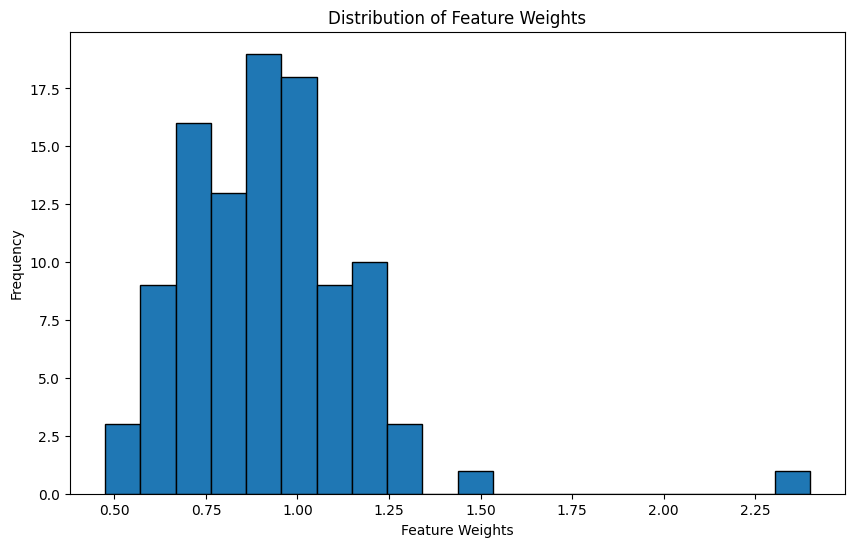

In [ ]:
# prompt: plot feature_weights in a distribution graph

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(feature_weights, bins=20, edgecolor='black')
plt.xlabel('Feature Weights')
plt.ylabel('Frequency')
plt.title('Distribution of Feature Weights')
plt.show()


## Inspecting one case

### Explanation for SST


In [ ]:
query = X_test[0]

In [ ]:
query.shape

torch.Size([56])

In [ ]:
def classify_and_explain_sst(model, query, vocab, classes, device='cuda'):
    """
    Classify a query sentence and provide the most activated case as an explanation.

    Args:
        model (CaseNetsClassifier): Trained model for classification.
        query (torch.Tensor): Query tensor of shape [seq_len].
        case_nets (list): List of CaseNet objects.
        vocab (torchtext.vocab.Vocab): Vocabulary used for numericalization.
        classes (list): List of class names for the dataset.
        device (str): Device to run the inference on ('cuda' or 'cpu').

    Returns:
        dict: Results containing predictions and explanation.
    """
    model = model.to(device)
    query = query.unsqueeze(0).to(device)  # Add batch dimension [1, seq_len]

    # Classify query and get explanation
    final_predictions, predicted_class, most_activated_cases, most_activated_case_labels, most_activated_activations = model(query)
    results = {"query": None,
                "query_prediction": classes[predicted_class.item()],
                "explanations": []}
    # Get the most activated case and its label
    for i, (case, label, activation) in enumerate(zip(most_activated_cases[0], most_activated_case_labels[0], most_activated_activations[0])):
        most_activated_case = case.cpu().squeeze()
        most_activated_label = torch.argmax(label).item()
        most_activated_activation = activation.item()

        # Decode query and most activated case from indices to tokens
        def decode(tokens, vocab):
            reverse_vocab = {idx: token for token, idx in vocab.items()}  # Create reverse mapping
            return " ".join([reverse_vocab[token.item()] for token in tokens if token.item() != vocab["<pad>"]])

        query_text = decode(query.squeeze().cpu(), vocab)
        results["query"] = query_text
        most_activated_case_text = decode(most_activated_case, vocab)
        # Append explanation to results
        results["explanations"].append({
            "most_activated_case": most_activated_case_text,
            "most_activated_case_label": classes[most_activated_label],
            "most_activated_activation": most_activated_activation
        })
    # Return detailed results
    return results


In [ ]:
model = last_model

In [ ]:
# Example usage
# Assume you have a trained CaseNetsClassifier `model`, SST data, and case_nets

# Select a query from the test dataset
query_idx = 3  # Example test query index
query = X_test[query_idx]  # No need to unsqueeze; function handles it
classes = ["Negative", "Positive"]  # SST binary classes
classes = ["Negative", "Somewhat Negative", "Neutral", "Somewhat Positive", "Positive"]
# Run the classify_and_explain_sst function
results = classify_and_explain_sst(model, query,  vocab, classes)

# Print the classification results
print("Classification Results:")
print(f"Query Sentence: {results['query']}")
print(f"Predicted Class: {results['query_prediction']}")
print(f"Most Activated Case Sentence: {results['most_activated_case']}")
print(f"Most Activated Case Label: {results['most_activated_case_label']}")
print(f"Most Activated Activation: {results['most_activated_activation']:.4f}")

Classification Results:
Query Sentence: The film provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .
Predicted Class: Somewhat Positive
Most Activated Case Sentence: It appears as if even the filmmakers did n't know what kind of movie they were making .
Most Activated Case Label: Negative
Most Activated Activation: 1.0433


In [ ]:
# model.sampling_cases = True
# model.sample_num = 500

In [ ]:
model.sampling_cases

True

In [ ]:
model.sample_num

500

In [ ]:
import random
random_indices = random.sample(range(len(X_test)), 20)

# Loop through the randomly selected queries
for i, query_idx in enumerate(random_indices):  # Loop through the first 20 test queries
    query = X_test[query_idx]  # Get numericalized query tensor
    true_class = y_test[query_idx]  # Get true class label
    # Run the classify_and_explain_sst function
    results = classify_and_explain_sst(model, query, vocab, classes)

    # Print the classification results
    print(f"--- Example {query_idx + 1} ---")
    print(f"Query Sentence: {results['query']}")
    print(f"True Class: {classes[true_class]}")
    print(f"Predicted Class: {results['query_prediction']}")
    print(f"Most Activated Case Sentence: {results['most_activated_case']}")
    print(f"Most Activated Case Label: {results['most_activated_case_label']}")
    print(f"Most Activated Activation: {results['most_activated_activation']:.4f}")
    print()

--- Example 1131 ---
Query Sentence: It 's got its heart in the right place , but it also wilts after awhile .
True Class: Neutral
Predicted Class: Somewhat Positive
Most Activated Case Sentence: What results is the best performance from either in years .
Most Activated Case Label: Positive
Most Activated Activation: 0.9847

--- Example 1820 ---
Query Sentence: You 've seen them a million times .
True Class: Somewhat Negative
Predicted Class: Somewhat Positive
Most Activated Case Sentence: Just a bunch of good actors flailing around in a caper that 's neither original nor terribly funny .
Most Activated Case Label: Negative
Most Activated Activation: 1.1683

--- Example 1908 ---
Query Sentence: The central story lacks punch .
True Class: Somewhat Negative
Predicted Class: Neutral
Most Activated Case Sentence: A limp Eddie Murphy vehicle that even he seems embarrassed to be part of .
Most Activated Case Label: Negative
Most Activated Activation: 1.1656

--- Example 1276 ---
Query Senten

###Explanation for CIFAR10

For CIFAR10

In [ ]:
model = last_model

In [ ]:
model.explanation_mode

False

In [ ]:
model.explanation_mode = True

In [ ]:
query = X_test[0]

In [ ]:
query.shape

torch.Size([3, 32, 32])

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def classify_and_explain(model, query, classes, device='cuda'):
    """
    Classify a query and provide the top activated cases as explanations.

    Args:
        model (CaseNetsClassifier): Trained model for classification.
        query (torch.Tensor): Query tensor of shape [1, channels, height, width].
        classes (list): List of class names for the dataset.
        device (str): Device to run the inference on ('cuda' or 'cpu').

    Returns:
        dict: Results containing predictions and explanations for the top cases.
    """
    model = model.to(device)
    query = query.to(device)

    # Classify query and get explanation
    final_predictions, predicted_class, most_activated_cases, most_activated_case_labels, most_activated_activations = model(query)

    # De-normalize the query for visualization
    mean, std = 0.4734, 0.2111  # Replace with your computed values
    transform = transforms.Compose([
        transforms.Normalize(mean=[-mean / std], std=[1 / std]),
        transforms.ToPILImage()
    ])
    query_image = transform(query.cpu().squeeze())

    # Visualization
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 5, 1)  # First plot for the query
    plt.imshow(query_image)
    plt.title(f"(Predicted: {classes[predicted_class.item()]})")
    plt.axis('off')
    #get top 3 class in final predictions
    top_3_indices = torch.topk(final_predictions, 3, dim=1)[1][0]
    #get their corresponding activations
    top_3_activations = torch.topk(final_predictions, 3, dim=1)[0][0]
    #get their corresponding classes
    top_3_classes = [classes[i] for i in top_3_indices]

    # Iterate over the top activated cases
    results = {"query_prediction": classes[predicted_class.item()],
               "top_3_classes": top_3_classes,
               "top_3_activations": top_3_activations,
               "explanations": []}
    for i, (case, label, activation) in enumerate(zip(most_activated_cases[0], most_activated_case_labels[0], most_activated_activations[0])):
        # Retrieve case information
        case_image = transform(case.cpu().squeeze())
        case_label = torch.argmax(label).item()
        case_activation = activation.item()

        # Visualization for the case
        plt.subplot(1, 5, i + 2)  # Next plots for the top cases
        plt.imshow(case_image)
        plt.title(f"Act: {case_activation:.4f}")
        plt.axis('off')

        # Append explanation to results
        results["explanations"].append({
            "case_label": classes[case_label],
            "activation": case_activation
        })

    plt.tight_layout()
    plt.show()

    # Return detailed results
    return results


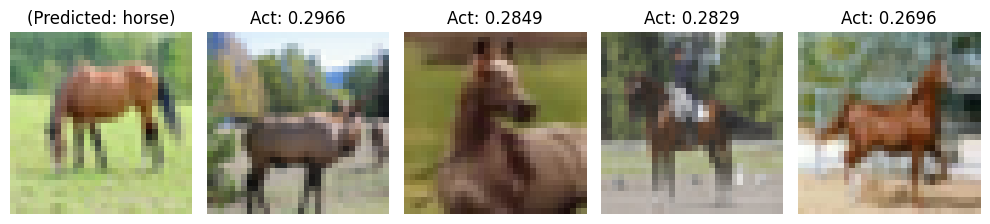

--- Query 61 ---
True Class: horse
Predicted Class: horse
Top 3 Classes: horse, deer, bird
Top 3 Activations: 6.3948, 3.6399, 2.9502
  Case 1:
    Label: deer
    Activation: 0.2966
  Case 2:
    Label: horse
    Activation: 0.2849
  Case 3:
    Label: horse
    Activation: 0.2829
  Case 4:
    Label: horse
    Activation: 0.2696



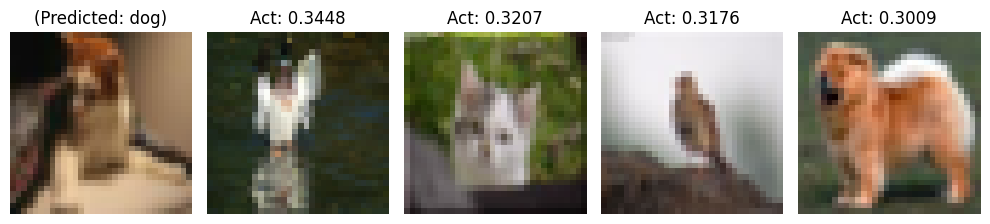

--- Query 62 ---
True Class: cat
Predicted Class: dog
Top 3 Classes: dog, cat, bird
Top 3 Activations: 6.4953, 5.0862, 5.0759
  Case 1:
    Label: bird
    Activation: 0.3448
  Case 2:
    Label: cat
    Activation: 0.3207
  Case 3:
    Label: bird
    Activation: 0.3176
  Case 4:
    Label: dog
    Activation: 0.3009



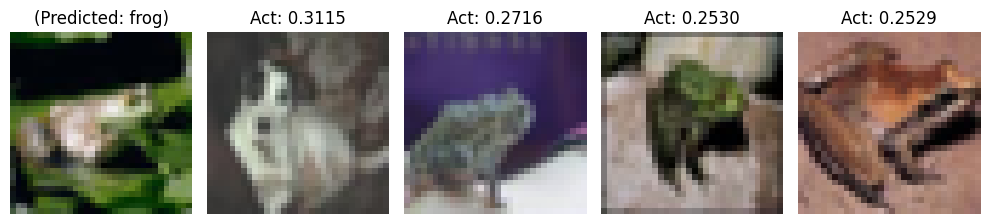

--- Query 63 ---
True Class: frog
Predicted Class: frog
Top 3 Classes: frog, cat, dog
Top 3 Activations: 5.3121, 3.9413, 3.2707
  Case 1:
    Label: dog
    Activation: 0.3115
  Case 2:
    Label: frog
    Activation: 0.2716
  Case 3:
    Label: frog
    Activation: 0.2530
  Case 4:
    Label: frog
    Activation: 0.2529



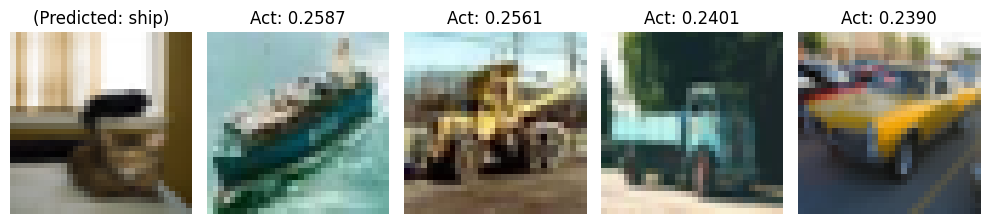

--- Query 64 ---
True Class: cat
Predicted Class: ship
Top 3 Classes: ship, bird, truck
Top 3 Activations: 4.3949, 4.3475, 4.2972
  Case 1:
    Label: ship
    Activation: 0.2587
  Case 2:
    Label: truck
    Activation: 0.2561
  Case 3:
    Label: truck
    Activation: 0.2401
  Case 4:
    Label: automobile
    Activation: 0.2390



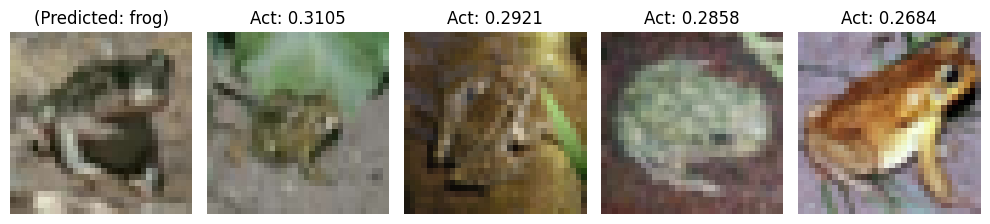

--- Query 65 ---
True Class: frog
Predicted Class: frog
Top 3 Classes: frog, cat, bird
Top 3 Activations: 6.5974, 3.5932, 3.3371
  Case 1:
    Label: frog
    Activation: 0.3105
  Case 2:
    Label: frog
    Activation: 0.2921
  Case 3:
    Label: frog
    Activation: 0.2858
  Case 4:
    Label: frog
    Activation: 0.2684



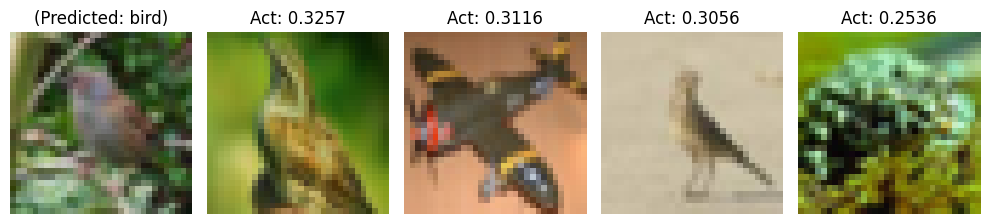

--- Query 66 ---
True Class: bird
Predicted Class: bird
Top 3 Classes: bird, frog, cat
Top 3 Activations: 4.2014, 3.6022, 3.1895
  Case 1:
    Label: bird
    Activation: 0.3257
  Case 2:
    Label: airplane
    Activation: 0.3116
  Case 3:
    Label: bird
    Activation: 0.3056
  Case 4:
    Label: frog
    Activation: 0.2536



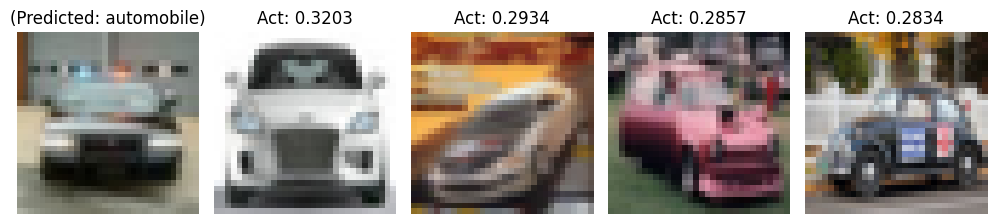

--- Query 67 ---
True Class: automobile
Predicted Class: automobile
Top 3 Classes: automobile, ship, truck
Top 3 Activations: 5.7759, 4.8424, 4.1209
  Case 1:
    Label: automobile
    Activation: 0.3203
  Case 2:
    Label: automobile
    Activation: 0.2934
  Case 3:
    Label: automobile
    Activation: 0.2857
  Case 4:
    Label: automobile
    Activation: 0.2834



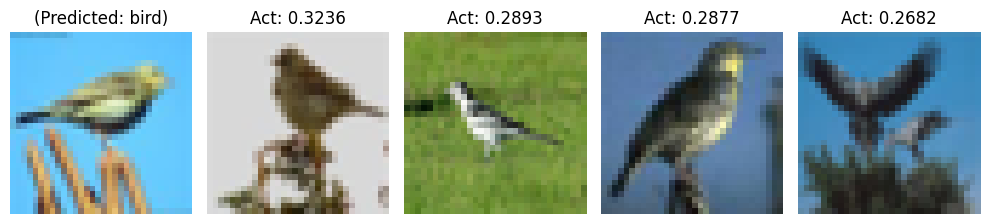

--- Query 68 ---
True Class: bird
Predicted Class: bird
Top 3 Classes: bird, ship, airplane
Top 3 Activations: 5.6180, 4.0628, 3.7788
  Case 1:
    Label: bird
    Activation: 0.3236
  Case 2:
    Label: bird
    Activation: 0.2893
  Case 3:
    Label: bird
    Activation: 0.2877
  Case 4:
    Label: bird
    Activation: 0.2682



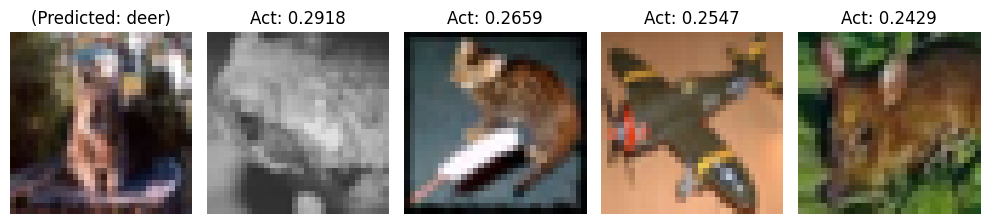

--- Query 69 ---
True Class: cat
Predicted Class: deer
Top 3 Classes: deer, cat, frog
Top 3 Activations: 5.0158, 4.5077, 4.2278
  Case 1:
    Label: frog
    Activation: 0.2918
  Case 2:
    Label: cat
    Activation: 0.2659
  Case 3:
    Label: airplane
    Activation: 0.2547
  Case 4:
    Label: deer
    Activation: 0.2429



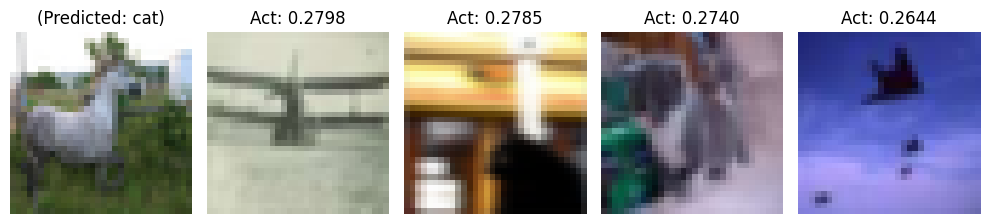

--- Query 70 ---
True Class: horse
Predicted Class: cat
Top 3 Classes: cat, horse, truck
Top 3 Activations: 4.4678, 4.2829, 4.0710
  Case 1:
    Label: airplane
    Activation: 0.2798
  Case 2:
    Label: cat
    Activation: 0.2785
  Case 3:
    Label: cat
    Activation: 0.2740
  Case 4:
    Label: airplane
    Activation: 0.2644



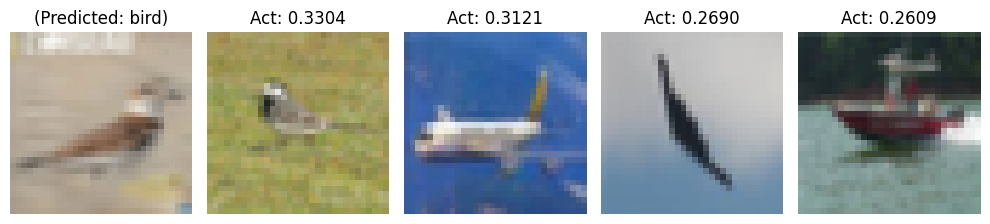

--- Query 71 ---
True Class: bird
Predicted Class: bird
Top 3 Classes: bird, deer, cat
Top 3 Activations: 5.5855, 4.6691, 4.5038
  Case 1:
    Label: bird
    Activation: 0.3304
  Case 2:
    Label: airplane
    Activation: 0.3121
  Case 3:
    Label: airplane
    Activation: 0.2690
  Case 4:
    Label: ship
    Activation: 0.2609



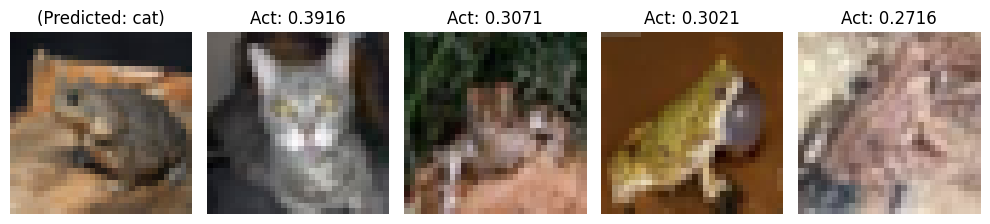

--- Query 72 ---
True Class: frog
Predicted Class: cat
Top 3 Classes: cat, frog, deer
Top 3 Activations: 5.4705, 5.0755, 4.0905
  Case 1:
    Label: cat
    Activation: 0.3916
  Case 2:
    Label: frog
    Activation: 0.3071
  Case 3:
    Label: frog
    Activation: 0.3021
  Case 4:
    Label: frog
    Activation: 0.2716



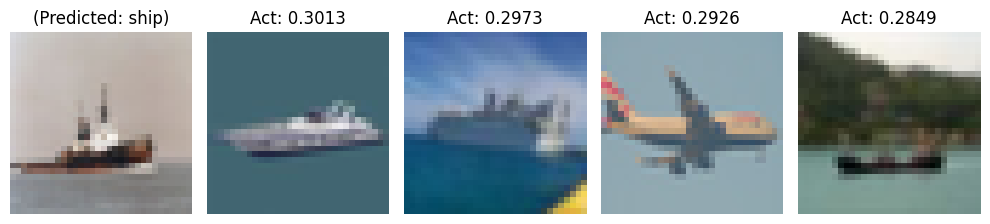

--- Query 73 ---
True Class: ship
Predicted Class: ship
Top 3 Classes: ship, airplane, bird
Top 3 Activations: 5.6369, 3.9075, 3.0146
  Case 1:
    Label: ship
    Activation: 0.3013
  Case 2:
    Label: ship
    Activation: 0.2973
  Case 3:
    Label: airplane
    Activation: 0.2926
  Case 4:
    Label: ship
    Activation: 0.2849



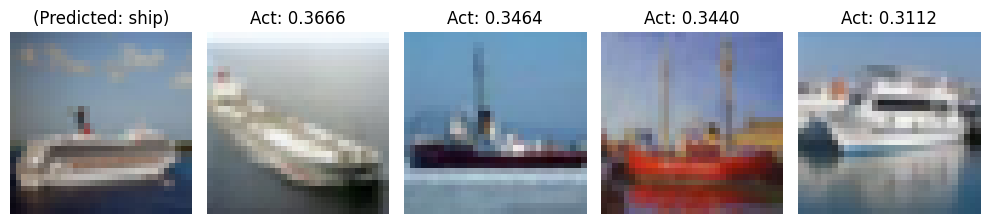

--- Query 74 ---
True Class: ship
Predicted Class: ship
Top 3 Classes: ship, airplane, automobile
Top 3 Activations: 6.2821, 3.5351, 2.7537
  Case 1:
    Label: ship
    Activation: 0.3666
  Case 2:
    Label: ship
    Activation: 0.3464
  Case 3:
    Label: ship
    Activation: 0.3440
  Case 4:
    Label: ship
    Activation: 0.3112



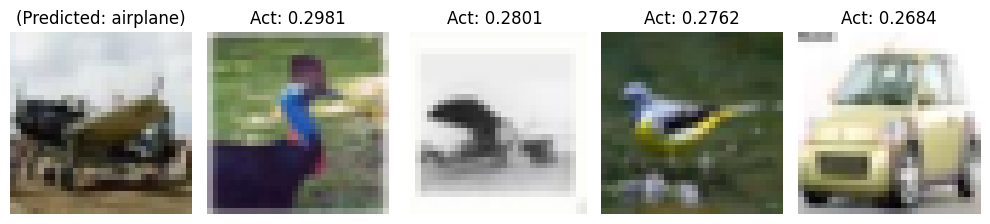

--- Query 75 ---
True Class: airplane
Predicted Class: airplane
Top 3 Classes: airplane, truck, bird
Top 3 Activations: 4.5058, 4.3218, 3.7100
  Case 1:
    Label: bird
    Activation: 0.2981
  Case 2:
    Label: airplane
    Activation: 0.2801
  Case 3:
    Label: bird
    Activation: 0.2762
  Case 4:
    Label: automobile
    Activation: 0.2684



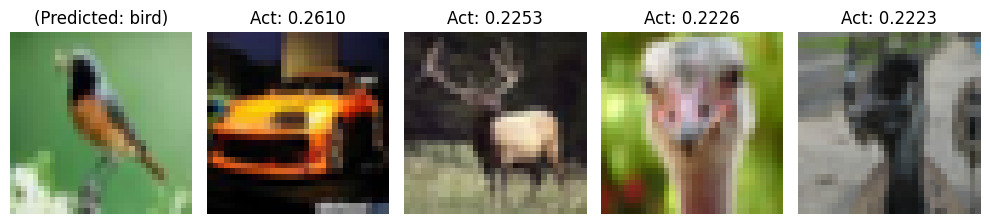

--- Query 76 ---
True Class: bird
Predicted Class: bird
Top 3 Classes: bird, horse, deer
Top 3 Activations: 3.5095, 3.2676, 3.0630
  Case 1:
    Label: automobile
    Activation: 0.2610
  Case 2:
    Label: deer
    Activation: 0.2253
  Case 3:
    Label: bird
    Activation: 0.2226
  Case 4:
    Label: bird
    Activation: 0.2223



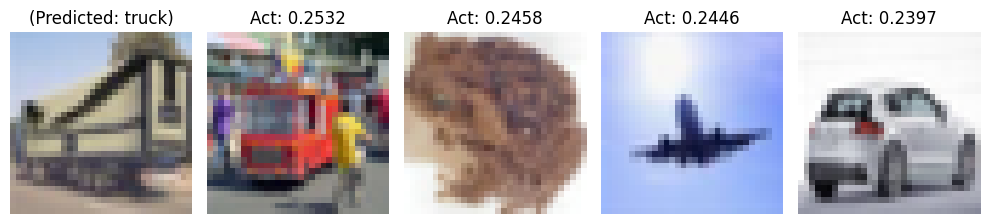

--- Query 77 ---
True Class: truck
Predicted Class: truck
Top 3 Classes: truck, ship, airplane
Top 3 Activations: 4.0720, 3.7881, 3.7288
  Case 1:
    Label: truck
    Activation: 0.2532
  Case 2:
    Label: frog
    Activation: 0.2458
  Case 3:
    Label: airplane
    Activation: 0.2446
  Case 4:
    Label: automobile
    Activation: 0.2397



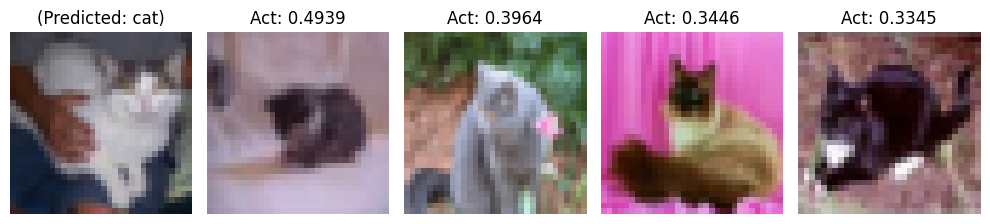

--- Query 78 ---
True Class: cat
Predicted Class: cat
Top 3 Classes: cat, deer, frog
Top 3 Activations: 7.1966, 4.5929, 4.0327
  Case 1:
    Label: cat
    Activation: 0.4939
  Case 2:
    Label: cat
    Activation: 0.3964
  Case 3:
    Label: cat
    Activation: 0.3446
  Case 4:
    Label: cat
    Activation: 0.3345



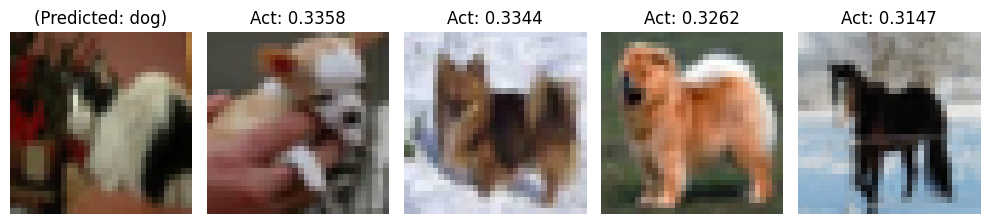

--- Query 79 ---
True Class: cat
Predicted Class: dog
Top 3 Classes: dog, cat, horse
Top 3 Activations: 6.8222, 4.9256, 4.7357
  Case 1:
    Label: dog
    Activation: 0.3358
  Case 2:
    Label: dog
    Activation: 0.3344
  Case 3:
    Label: dog
    Activation: 0.3262
  Case 4:
    Label: horse
    Activation: 0.3147



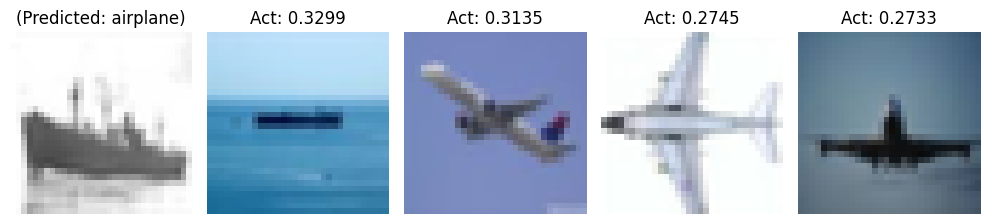

--- Query 80 ---
True Class: ship
Predicted Class: airplane
Top 3 Classes: airplane, ship, truck
Top 3 Activations: 5.6024, 4.0390, 3.2805
  Case 1:
    Label: ship
    Activation: 0.3299
  Case 2:
    Label: airplane
    Activation: 0.3135
  Case 3:
    Label: airplane
    Activation: 0.2745
  Case 4:
    Label: airplane
    Activation: 0.2733



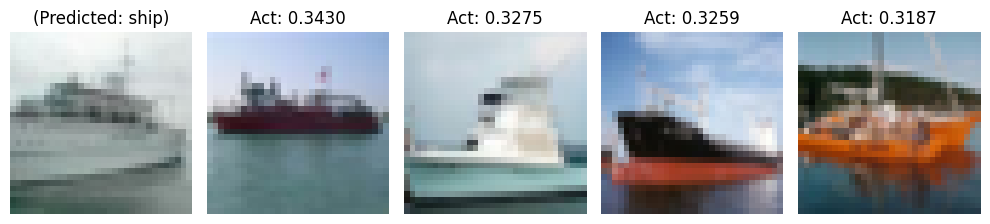

--- Query 81 ---
True Class: ship
Predicted Class: ship
Top 3 Classes: ship, airplane, truck
Top 3 Activations: 7.8807, 4.7798, 4.2817
  Case 1:
    Label: ship
    Activation: 0.3430
  Case 2:
    Label: ship
    Activation: 0.3275
  Case 3:
    Label: ship
    Activation: 0.3259
  Case 4:
    Label: ship
    Activation: 0.3187



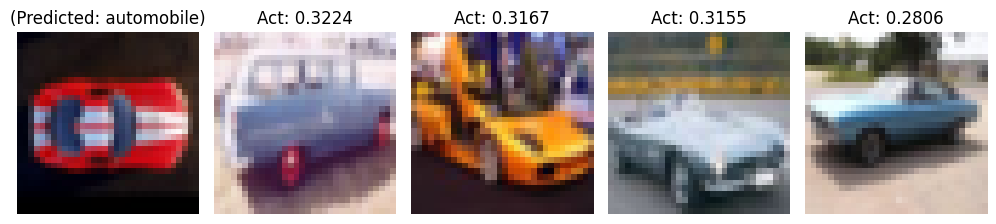

--- Query 82 ---
True Class: automobile
Predicted Class: automobile
Top 3 Classes: automobile, truck, ship
Top 3 Activations: 4.8998, 3.6116, 2.9536
  Case 1:
    Label: automobile
    Activation: 0.3224
  Case 2:
    Label: automobile
    Activation: 0.3167
  Case 3:
    Label: automobile
    Activation: 0.3155
  Case 4:
    Label: automobile
    Activation: 0.2806



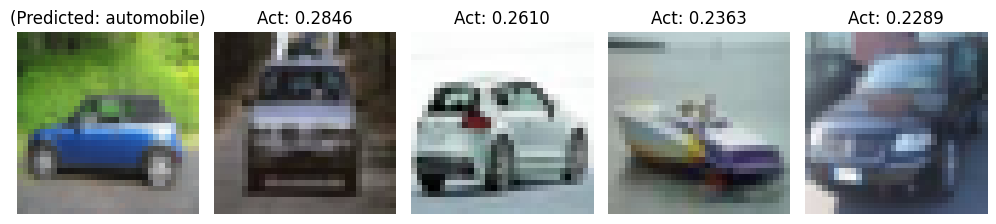

--- Query 83 ---
True Class: automobile
Predicted Class: automobile
Top 3 Classes: automobile, ship, airplane
Top 3 Activations: 4.2073, 3.0055, 2.4377
  Case 1:
    Label: automobile
    Activation: 0.2846
  Case 2:
    Label: automobile
    Activation: 0.2610
  Case 3:
    Label: ship
    Activation: 0.2363
  Case 4:
    Label: automobile
    Activation: 0.2289



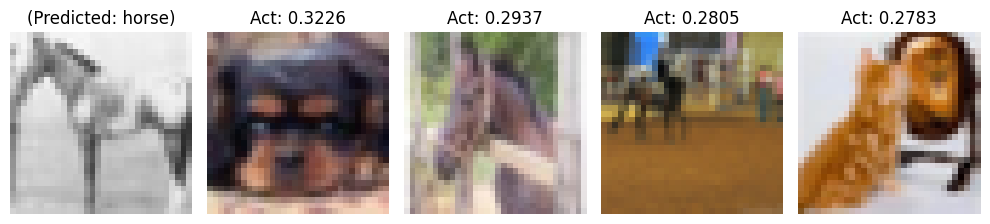

--- Query 84 ---
True Class: horse
Predicted Class: horse
Top 3 Classes: horse, dog, bird
Top 3 Activations: 5.7291, 4.7712, 4.0743
  Case 1:
    Label: dog
    Activation: 0.3226
  Case 2:
    Label: horse
    Activation: 0.2937
  Case 3:
    Label: horse
    Activation: 0.2805
  Case 4:
    Label: cat
    Activation: 0.2783



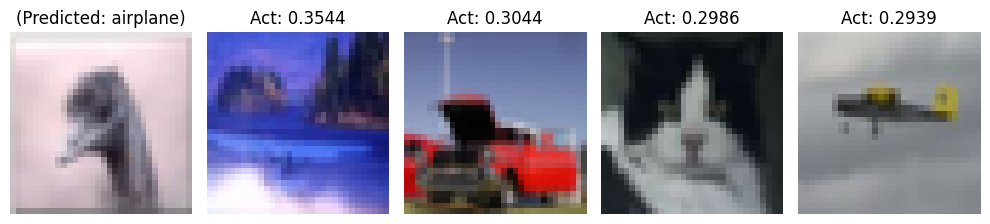

--- Query 85 ---
True Class: bird
Predicted Class: airplane
Top 3 Classes: airplane, bird, cat
Top 3 Activations: 5.2019, 3.8266, 3.6857
  Case 1:
    Label: airplane
    Activation: 0.3544
  Case 2:
    Label: automobile
    Activation: 0.3044
  Case 3:
    Label: cat
    Activation: 0.2986
  Case 4:
    Label: airplane
    Activation: 0.2939



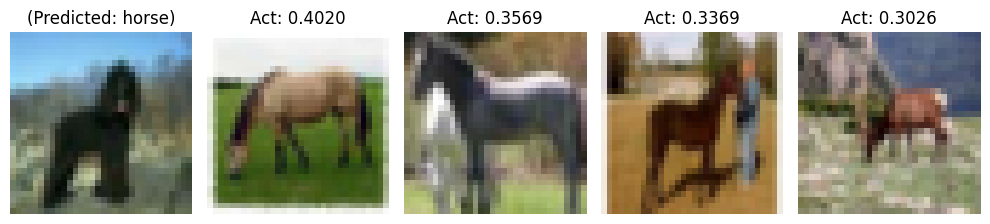

--- Query 86 ---
True Class: dog
Predicted Class: horse
Top 3 Classes: horse, deer, cat
Top 3 Activations: 6.3377, 4.4302, 3.5022
  Case 1:
    Label: horse
    Activation: 0.4020
  Case 2:
    Label: horse
    Activation: 0.3569
  Case 3:
    Label: horse
    Activation: 0.3369
  Case 4:
    Label: deer
    Activation: 0.3026



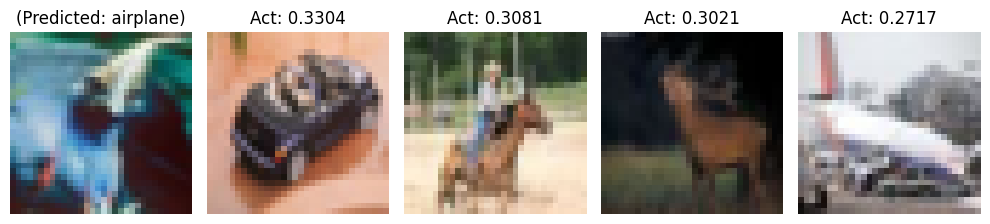

--- Query 87 ---
True Class: bird
Predicted Class: airplane
Top 3 Classes: airplane, cat, deer
Top 3 Activations: 4.9504, 4.8693, 4.8332
  Case 1:
    Label: automobile
    Activation: 0.3304
  Case 2:
    Label: horse
    Activation: 0.3081
  Case 3:
    Label: deer
    Activation: 0.3021
  Case 4:
    Label: airplane
    Activation: 0.2717



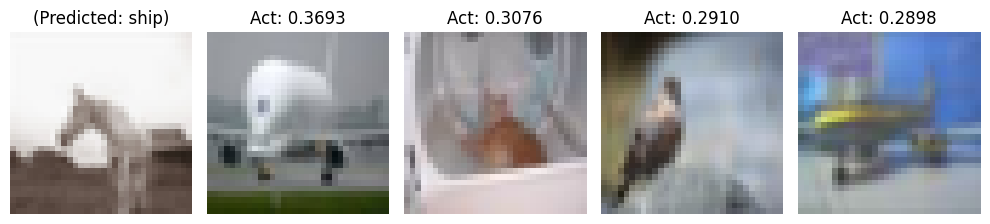

--- Query 88 ---
True Class: horse
Predicted Class: ship
Top 3 Classes: ship, airplane, cat
Top 3 Activations: 5.6295, 5.4969, 4.8480
  Case 1:
    Label: airplane
    Activation: 0.3693
  Case 2:
    Label: cat
    Activation: 0.3076
  Case 3:
    Label: bird
    Activation: 0.2910
  Case 4:
    Label: airplane
    Activation: 0.2898



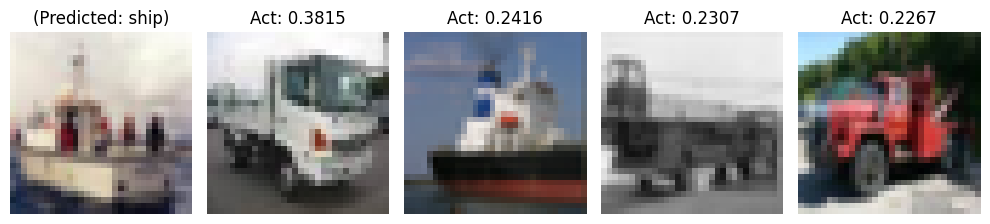

--- Query 89 ---
True Class: ship
Predicted Class: ship
Top 3 Classes: ship, truck, automobile
Top 3 Activations: 4.1658, 4.0701, 3.6349
  Case 1:
    Label: truck
    Activation: 0.3815
  Case 2:
    Label: ship
    Activation: 0.2416
  Case 3:
    Label: truck
    Activation: 0.2307
  Case 4:
    Label: truck
    Activation: 0.2267



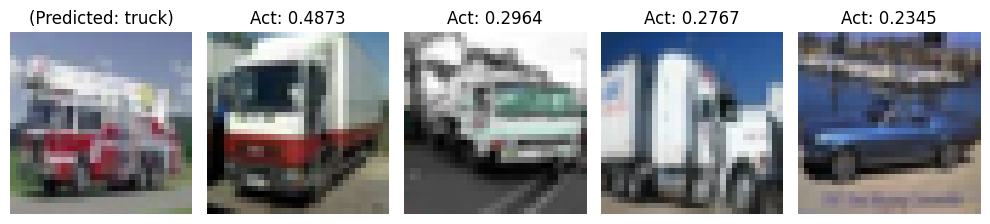

--- Query 90 ---
True Class: truck
Predicted Class: truck
Top 3 Classes: truck, automobile, ship
Top 3 Activations: 4.8704, 3.6301, 2.7915
  Case 1:
    Label: truck
    Activation: 0.4873
  Case 2:
    Label: truck
    Activation: 0.2964
  Case 3:
    Label: truck
    Activation: 0.2767
  Case 4:
    Label: automobile
    Activation: 0.2345



In [ ]:
num_queries = 30  # Number of queries to classify and explain
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]  # CIFAR-10 classes
stair = 60  # Offset for selecting queries from the test set

# Iterate through the selected `num_queries` test samples
for i in range(num_queries):
    query_idx = i + stair  # Offset query index
    query = X_test[query_idx].unsqueeze(0)  # Add batch dimension for the query
    true_label = y_test[query_idx].item()

    # Run the classify_and_explain function
    results = classify_and_explain(model, query, classes)

    # Print query details
    print(f"--- Query {query_idx + 1} ---")
    print(f"True Class: {classes[true_label]}")
    print(f"Predicted Class: {results['query_prediction']}")
    print(f"Top 3 Classes: {', '.join(results['top_3_classes'])}")
    print(f"Top 3 Activations: {', '.join([f'{a:.4f}' for a in results['top_3_activations']])}")

    # Print details of the top activated cases
    for j, explanation in enumerate(results["explanations"]):
        print(f"  Case {j + 1}:")
        print(f"    Label: {explanation['case_label']}")
        print(f"    Activation: {explanation['activation']:.4f}")
    print()


### 6.1 Tuning: Take out a case.

In [ ]:
X_train.shape

torch.Size([106, 102])

In [ ]:
def delete_one_case(X_train, y_train,index_to_remove):
  X_train = np.delete(X_train, index_to_remove, axis=0)
  y_train = np.delete(y_train, index_to_remove, axis=0)
  return X_train, y_train

In [ ]:
index_to_remove = 1
X_train, y_train = delete_one_case(X_train, y_train,index_to_remove)
#This will retrain a new mode, since one case is removed, the neural structure needs to change
best_accuracy, model = train_cls(X_train,y_train, X_test, y_test, cfg)
print("nnknn acc: ", best_accuracy)

knn =  KNeighborsClassifier(n_neighbors=cfg.top_k)
knn.fit(X_train, y_train)
knn_acc  = accuracy_score(knn.predict(X_test), y_test)
print("knn_acc: ", knn_acc)

Epoch [2/1000], Loss: 2.2368
Epoch [4/1000], Loss: 1.7523
Epoch [6/1000], Loss: 1.6548
Epoch [8/1000], Loss: 1.9043
Epoch [10/1000], Loss: 1.8448
Epoch [12/1000], Loss: 2.1528
Epoch [14/1000], Loss: 1.7320
Epoch [16/1000], Loss: 0.7989
Epoch [18/1000], Loss: 1.3409
Epoch [20/1000], Loss: 1.6985
Epoch [22/1000], Loss: 0.5673
Epoch [24/1000], Loss: 0.6184
Epoch [26/1000], Loss: 1.3486
Epoch [28/1000], Loss: 0.4975
Epoch [30/1000], Loss: 0.8670
Epoch [32/1000], Loss: 1.5546
Epoch [34/1000], Loss: 0.7518
Epoch [36/1000], Loss: 0.9713
Epoch [38/1000], Loss: 0.6471
Epoch [40/1000], Loss: 0.5468
Epoch [42/1000], Loss: 0.4549
Epoch [44/1000], Loss: 0.7913
patience exceeded, loading best model
nnknn acc:  0.6363636363636364
knn_acc:  0.36363636363636365


<ipython-input-308-735e1fd27a5e>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cfg.PATH))


In [ ]:
X_train.shape

torch.Size([105, 102])

In [ ]:
y_train.shape

torch.Size([105])

### 6.2 Tuning: Set a Case Weight

In [ ]:
model = Cmodel.NN_k_NN(X_train.to(device),
            y_train.to(device),
            cfg.ca_weight_sharing,
            cfg.top_case_enabled,
            cfg.top_k,
            cfg.discount,
            device=device)

def set_case_weight(index_to_set, value_to_set):
  # Create a copy of the weight tensor
  new_ca_weight = model.ca_layer.bias.clone()

  # Modify the copy
  new_ca_weight[index_to_set] = value_to_set

  # Assign the modified copy back to the model
  model.ca_layer.bias = torch.nn.Parameter(new_ca_weight)
  #We wrap the modified tensors with torch.nn.Parameter to
  #indicate that they are model parameters
  #and require gradient tracking.
  #This step is crucial if you want these modified weights to be updated during training.
  return model



In [ ]:
index_to_set = 2
value_to_set = 30.0  #average is 50
set_case_weight(index_to_set, value_to_set)

NN_k_NN(
  (fa_layer): FeatureActivationLayer()
  (ca_layer): CaseActivationLayer()
  (selection_layer): TopCaseLayer()
  (class_layer): ClassActivationLayer()
)

In [ ]:
print("accuracy before tuning: ",best_accuracy)
# Get training and testing data
X_train, X_test = Xs[train_index], Xs[test_index]
y_train, y_test = ys[train_index], ys[test_index]
#model = load_model_cls(X_train,y_train, cfg)
model.to(device)
best_accuracy, model = continue_training_cls(model, X_train,y_train, X_test, y_test, cfg)
print("accuracy after tuning: ",best_accuracy)

accuracy before tuning:  0.6363636363636364
X_train.device:  cuda:0
Epoch [2/1000], Loss: 2.7635
Epoch [4/1000], Loss: 2.0068
Epoch [6/1000], Loss: 2.1952
Epoch [8/1000], Loss: 1.9042
Epoch [10/1000], Loss: 2.7107
Epoch [12/1000], Loss: 1.3669
Epoch [14/1000], Loss: 1.9472
Epoch [16/1000], Loss: 1.3284
Epoch [18/1000], Loss: 1.2807
Epoch [20/1000], Loss: 1.5995
Epoch [22/1000], Loss: 1.4912
Epoch [24/1000], Loss: 0.7788
Epoch [26/1000], Loss: 0.7408
Epoch [28/1000], Loss: 0.8269
Epoch [30/1000], Loss: 0.7614
Epoch [32/1000], Loss: 1.3145
Epoch [34/1000], Loss: 0.3060
Epoch [36/1000], Loss: 0.7273
Epoch [38/1000], Loss: 0.5476
Epoch [40/1000], Loss: 0.9147
Epoch [42/1000], Loss: 0.3176
patience exceeded, loading best model
accuracy after tuning:  0.5454545454545454


### 6.3 Inspecting Case weights

In [ ]:
# prompt: inspecting ca_layer.bias

# Access the ca_layer.bias parameter
ca_weight = model.ca_layer.bias

# Get the top 5 bias with the highest absolute values
top_5_ca = torch.topk(torch.abs(ca_weight), k=5)[1]

# Print the top 5 features
print(f"Top 5 cases of ca_layer.ca_weight:")
for i in range(5):
    print(f"\tCase {top_5_ca[i]} bias: {ca_weight[top_5_ca[i]]}")

# Get the indices of the top 5 features
top_5_indices = top_5_ca.tolist()

print(X_train[top_5_ca.cpu()])
print(y_train[top_5_ca.cpu()])

# Access the ca_layer.bias parameter
ca_weight = model.ca_layer.bias

# Get the top 5 features with the highest absolute values
top_5_ca = torch.topk(torch.abs(ca_weight), k=5, largest=False)[1]

# Print the top 5 features
print(f"Least 5 cases of ca_layer.ca_weight:")
for i in range(5):
    print(f"\tCase {top_5_ca[i]} bias: {ca_weight[top_5_ca[i]]}")

# Get the indices of the top 5 features
top_5_indices = top_5_ca.tolist()

print(X_train[top_5_ca.cpu()])
print(y_train[top_5_ca.cpu()])

Top 5 cases of ca_layer.ca_weight:
	Case 6 bias: 51.600059509277344
	Case 90 bias: 51.52865219116211
	Case 7 bias: 51.42941665649414
	Case 0 bias: 51.42817687988281
	Case 51 bias: 51.39358139038086
tensor([[0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
         0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
         1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0.,
         1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
         0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
         0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
         1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
         0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1.,
         1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0.,
         0., 0.

### 6.4 Find the nearest neighbor

In [ ]:
test_case_index = 1 # you are looking at query of test_case_index+1

In [ ]:
X_test.shape

torch.Size([10000, 3, 32, 32])

In [ ]:
model= last_model

NameError: name 'last_model' is not defined

In [ ]:
# for regression only. for classification is different
#feature_activations, case_activations, predicted_number
model.eval()
final_predictions, predicted_class,  most_activated_cases, most_activated_activations = model(X_test.to(device))

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.38 GiB. GPU 0 has a total capacity of 14.75 GiB of which 1.84 GiB is free. Process 5943 has 12.90 GiB memory in use. Of the allocated memory 9.33 GiB is allocated by PyTorch, and 3.45 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
predicted_class

tensor([5, 8, 8,  ..., 5, 1, 7], device='cuda:0')

In [ ]:
y_test

tensor([3, 8, 8,  ..., 5, 1, 7])

In [ ]:
# prompt: accuracy comparing predicted_class and y_test

accuracy = accuracy_score(y_test.numpy(), predicted_class.cpu().numpy())
print("Accuracy:", accuracy)


Accuracy: 0.6551


In [ ]:
#inspecting the case activations
top_case_indices = torch.topk(case_activations, 5, dim=1)[1]

NameError: name 'case_activations' is not defined

Features of test_case_index

In [ ]:
X_test[test_case_index]

tensor([1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0.,
        0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0.,
        1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1.])

True label of first test case

In [ ]:
y_test[test_case_index]

tensor(1)

Top case index below:

In [ ]:
top_case_indices[test_case_index][0]

tensor(2, device='cuda:0')

Feature of the retrieved case

In [ ]:
X_train[top_case_indices[test_case_index][0]]

tensor([0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
        1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0.,
        0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.])

Label of the retrieved case

In [ ]:
y_train[top_case_indices[test_case_index][0]]

tensor(1)

By comparing the following two blocks' outputs, you can see we are retrieving a good neighbor.

The difference between retrieved case and the query.

In [ ]:
#sum abs of X_test[0] and the top activated case
cur_diff = sum(abs(X_test[test_case_index] - X_train[top_case_indices[test_case_index][0]]))
print(cur_diff)

tensor(30.)


The following shows the average difference between a random case and the query

In [ ]:
# prompt: average sum abs of X_test[0] and X_train data
print(np.mean([sum(abs(X_test[test_case_index] - X_train[i])) for i in range(len(X_train))]))

30.59434


TODO:: A better way is to show the distribution of ``X_test[0] - X_train[i]``

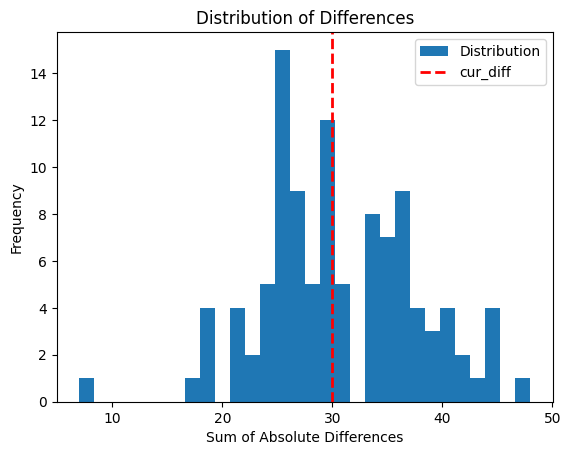

In [ ]:
# prompt: get the distributino of [sum(abs(X_test[0] - X_train[i])) for i in range(len(X_train))],
# put the cur_diff in the distribution, but with a different color to highlight it

import matplotlib.pyplot as plt

# Calculate the distribution
distribution = [sum(abs(X_test[test_case_index] - X_train[i])) for i in range(len(X_train))]

# Plot the distribution
plt.hist(distribution, bins=30, label='Distribution')

# Highlight cur_diff
plt.axvline(cur_diff, color='red', linestyle='dashed', linewidth=2, label='cur_diff')

plt.xlabel('Sum of Absolute Differences')
plt.ylabel('Frequency')
plt.title('Distribution of Differences')
plt.legend()
plt.show()


### 6.5 Show the two cases side by side, highlighting top and least important features

In [ ]:
def side_by_side_feature_comparison(f1, f2, five_features):
  for i in range(num_features_to_show):
      print(f"Feature {five_features[i]}: {f1[five_features[i]]} vs {f2[five_features[i]]}")
      print("\t"+columns[five_features[i]])

In [ ]:
#side by side comparison of their labels
print(y_test[test_case_index], " vs ", y_train[top_case_indices[test_case_index][0]])

tensor(1)  vs  tensor(1)


In [ ]:
side_by_side_feature_comparison(X_test[test_case_index], X_train[top_case_indices[test_case_index][0]], top_5_features)
#left is new client (query)
#right is the retrieved case

Feature 6: 1.0 vs 1.0
	7. My hobbies are still important to me
Feature 60: 1.0 vs 0.0
	61. Sometimes I forget what I wanted to say because I have several thoughts at the same time
Feature 73: 1.0 vs 1.0
	74. People have problems because of themselves
Feature 59: 1.0 vs 1.0
	60. In new situations I feel calm and encouraged
Feature 63: 1.0 vs 1.0
	64. I can put down my cell phone and dedicate myself to reading without distractions
Feature 95: 0.0 vs 0.0
	96. Littering on public roads is wrong
Feature 74: 0.0 vs 0.0
	75. No me parece importante lo que los otros piensen sobre mí
Feature 96: 0.0 vs 0.0
	97. People who commit crimes have their reasons for doing it
Feature 49: 1.0 vs 0.0
	50. I imagine that at any moment a disaster of the
nature may occur
Feature 52: 1.0 vs 1.0
	53. I'm bothered by people walking slowly in front of me 


In [ ]:
side_by_side_feature_comparison(X_test[test_case_index], X_train[top_case_indices[test_case_index][0]], least_5_features)

Feature 55: 1.0 vs 1.0
	56. I manage my schedule as I always have
Feature 68: 1.0 vs 0.0
	69. It is not important for me to meet set dates
Feature 101: 1.0 vs 1.0
	102. I have a hard time taking  "no" for an answer
Feature 34: 1.0 vs 0.0
	35. I constantly imagine that something will go wrong at my work or at school
Feature 91: 0.0 vs 0.0
	92. It does not seem serious to me to have some debts
Feature 4: 0.0 vs 1.0
	5. People around me often ask me how I feel
Feature 72: 1.0 vs 0.0
	73. I have difficulty making elaborate plans
Feature 36: 0.0 vs 0.0
	37. I'm not too worried about what might happen in a few weeks
Feature 94: 1.0 vs 1.0
	95. Neighbors must put up with each other's noises without complaining
Feature 100: 1.0 vs 0.0
	101. I consider it important that all people have the same rights


###Try the same thing on knn

In [ ]:
knn.predict(X_test)

array([1, 1, 1, 2, 1, 0, 2, 2, 1, 1, 0])

In [ ]:
y_test

tensor([0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1])

In [ ]:
indices = knn.kneighbors(X_test)[1][0]

In [ ]:
y_train[indices]

tensor([2, 1, 1, 2, 1])

In [ ]:
X_train[indices[0]]

tensor([1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.,
        0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
        1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1.])

In [ ]:
print(X_train[indices[0]].tolist())

[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0]


In [ ]:
y_train[indices[0]]

tensor(2)

In [ ]:
sum(abs(X_test[0] - X_train[indices[0]]))

tensor(28.)

In [ ]:
#side by side comparison of labels
print(y_test[0], " vs ", y_train[indices[0]])

tensor(0)  vs  tensor(2)


In [ ]:
side_by_side_feature_comparison(X_test[0], X_train[indices[0]], top_5_features)

Feature 94: 1.0 vs 1.0
	95. Neighbors must put up with each other's noises without complaining
Feature 79: 1.0 vs 0.0
	80. It is important to help people when they need it
Feature 99: 1.0 vs 1.0
	100. I could pretend to be someone else to achieve what I want
Feature 88: 1.0 vs 0.0
	89. It makes me laugh when my superiors at school or at work demand something
Feature 46: 0.0 vs 1.0
	47. I can clearly express to others how I feel
Feature 12: 1.0 vs 1.0
	13. I felt more encouraged to do my daily activities before
Feature 80: 0.0 vs 0.0
	81. I have punched someone or thought of doing it
Feature 8: 1.0 vs 1.0
	9. If I had the chance, I would spend all day in my bed
Feature 22: 0.0 vs 1.0
	23. I have thought more than before about what my death would be like
Feature 42: 0.0 vs 1.0
	43. Sometimes i feel trapped


In [ ]:
side_by_side_feature_comparison(X_test[0], X_train[indices[0]], least_5_features)

Feature 50: 0.0 vs 0.0
	51. Sometimes I feel like I get tired easily
Feature 28: 1.0 vs 1.0
	29. I am able to carry out my activities as I have always been
Feature 55: 1.0 vs 0.0
	56. I manage my schedule as I always have
Feature 35: 0.0 vs 1.0
	36. I am afraid of being worng when doing my homework
Feature 84: 1.0 vs 1.0
	85. I have a hard time controlling myself when I get angry
Feature 72: 1.0 vs 1.0
	73. I have difficulty making elaborate plans
Feature 44: 1.0 vs 1.0
	45. I have difficulties to do one task at a time
Feature 6: 1.0 vs 1.0
	7. My hobbies are still important to me
Feature 58: 0.0 vs 0.0
	59. I consider that I am good at controlling my emotions
Feature 20: 1.0 vs 1.0
	21. I'm capable of achieving what I propose to myself


# Sanity Check


## Classification Neural Network

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.1, random_state=42)

In [ ]:
# Hyperparameters
input_size = X_train.shape[1]
hidden_size = 1024
num_classes = torch.unique(ys).shape[0]
learning_rate = 1e-5
batch_size = 16
epochs = 2000

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the neural network architecture for classification
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.nn = nn.Sequential(
            nn.Linear(input_size, hidden_size ),
            nn.LeakyReLU(),
            nn.Linear(hidden_size , hidden_size // 2),
            # nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            # nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(hidden_size // 4, num_classes)
            )
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.fill_(0)

    def forward(self, x):
        return self.nn(x)


In [ ]:
from sklearn.model_selection import KFold
best_accuracies = []
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in k_fold.split(Xs):
  train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
  patience_counter = 0
  best_model = None
  best_accuracy = None
  best_val_loss = float('inf')
  # Initialize the model, loss function, and optimizer
  model = NeuralNet(input_size, hidden_size, num_classes)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Training loop
  for epoch in range(epochs):
    epoch_msg = True
    training_total_acc = 0.0
    training_total_loss = 0.0
    num_of_batches = len(train_loader)
    for X_train_batch, y_train_batch in train_loader:
      model.train()
      # Forward pass
      outputs = model(X_train_batch)
      loss = criterion(outputs, y_train_batch)

      # Backward and optimize
      _, predicted = torch.max(outputs, 1)
      training_total_acc += torch.sum(predicted == y_train_batch).item()

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      training_total_loss += loss.item()
      # if (i + 1) % 5 == 0
    if epoch == 0 or (epoch + 1) % 100 == 0:
      print(f"Epoch: {epoch + 1}, Training Loss: {training_total_loss/num_of_batches:.2f} Acc: {training_total_acc/num_of_batches:.2f}")
    # Testing the model
    model.eval()
    with torch.no_grad():
      outputs = model(X_test)
      val_loss = criterion(outputs, y_test).item()
      _, predicted = torch.max(outputs, 1)
      #print(f'Accuracy on the test set: {accuracy * 100:.2f}%')

      if best_accuracy is None or val_loss < best_val_loss:
        accuracy = torch.sum(predicted == y_test).item() / len(y_test)
        best_accuracy = accuracy
        best_model = model
        patience_counter = 0
        print(f'best Loss on the test set: {val_loss:.4f}')
      else:
        patience_counter += 1
      if epoch_msg and (epoch + 1) % 100 == 0:
        epoch_msg = False
        print(f'Epoch [{epoch + 1}/{epoch}], Test Loss: {val_loss:.4f}')
    if patience_counter >= cfg.patience:
      print("Best acc achieved: ", best_accuracy)
      break
  best_accuracies.append(best_accuracy)
  # break
print("NN Average accuracy:", np.mean(best_accuracies))

Streaming output truncated to the last 5000 lines.
Loss on the test set: 0.6398515701293945
Loss on the test set: 0.6510896682739258
Loss on the test set: 0.6798531413078308
Loss on the test set: 0.6510986685752869
Loss on the test set: 0.6413260698318481
Loss on the test set: 0.6345027089118958
Loss on the test set: 0.6384168267250061
Loss on the test set: 0.6131357550621033
Loss on the test set: 0.6214523315429688
Loss on the test set: 0.6306138634681702
Loss on the test set: 0.6088729500770569
Loss on the test set: 0.6451324820518494
Loss on the test set: 0.6159303188323975
Loss on the test set: 0.6046801209449768
Loss on the test set: 0.6133671402931213
Loss on the test set: 0.6129049062728882
Loss on the test set: 0.6095035076141357
Loss on the test set: 0.6344204545021057
Loss on the test set: 0.7299118041992188
Loss on the test set: 0.6396318674087524
Loss on the test set: 0.611653745174408
Loss on the test set: 0.6389526128768921
Loss on the test set: 0.6501991152763367
Loss on

KeyboardInterrupt: 

In [ ]:
print("NN Average accuracy:", np.mean(best_accuracies))

NN Average accuracy: 0.6477272727272727


## Regression Neural Network

In [ ]:
# Hyperparameters
input_size = X_train.shape[1]
hidden_size = 100
# num_classes = torch.unique(ys).shape[0]
learning_rate = 1e-5
batch_size = 16
epochs = 2000

In [ ]:
# prompt: a standard neural network with 3 fully connected layers for regression

import torch
import torch.nn as nn
import torch.nn.functional as F

class RegressionNet(nn.Module):
    def __init__(self, input_size):
        super(RegressionNet, self).__init__()
        self.nn = nn.Sequential(
            nn.Linear(input_size, hidden_size ),
            nn.LeakyReLU(),
            nn.Linear(hidden_size , hidden_size // 2),
            # nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            # nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(hidden_size // 4, 1)
            )
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.fill_(0)

    def forward(self, x):
        return self.nn(x).squeeze()

In [ ]:
best_accuracies = []
for train_index, test_index in k_fold.split(Xs):
  # Get training and testing data
  X_train, X_test = Xs[train_index], Xs[test_index]
  y_train, y_test = ys[train_index], ys[test_index]
  train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
  patience_counter = 0
  best_model = None
  best_accuracy = None
  model = RegressionNet(Xs.shape[1])
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  for epoch in range(epochs):
    epoch_msg = True
    training_total_loss = 0.0
    num_of_batches = len(train_loader)
    for X_train_batch, y_train_batch in train_loader:
      model.train()
      # Forward pass
      outputs = model(X_train_batch)
      loss = criterion(outputs, y_train_batch)
      training_total_loss += loss.item()
      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    if epoch == 0 or (epoch + 1) % 3 == 0:
      print(f'Epoch: {epoch + 1}, Training Loss: {training_total_loss/num_of_batches:.2f}')

    # Testing the model
    model.eval()
    with torch.no_grad():
      outputs = model(X_test)
      loss = criterion(outputs, y_test)
      if best_accuracy is None or loss.item() < best_accuracy:
        best_accuracy = loss.item()
        best_model = model
        patience_counter = 0
      else:
        patience_counter += 1
      if epoch_msg and (epoch + 1) % 100 == 0:
        epoch_msg = False
        print(f'Epoch [{epoch + 1}/{epochs}], Test Loss: {loss.item()}')
        # print(f'Loss on the test set: {loss.item()}')
    if patience_counter >= cfg.patience:
      print("Best loss achieved: ", best_accuracy)
      break
  best_accuracies.append(best_accuracy)
print("NN Average accuracy:", np.mean(best_accuracies))


Epoch: 1, Training Loss: 1.15
Epoch: 3, Training Loss: 1.11
Epoch: 6, Training Loss: 1.06
Epoch: 9, Training Loss: 1.01
Epoch: 12, Training Loss: 0.97
Epoch: 15, Training Loss: 0.92
Epoch: 18, Training Loss: 0.89
Epoch: 21, Training Loss: 0.86
Epoch: 24, Training Loss: 0.82
Epoch: 27, Training Loss: 0.79
Epoch: 30, Training Loss: 0.76
Epoch: 33, Training Loss: 0.74
Epoch: 36, Training Loss: 0.71
Epoch: 39, Training Loss: 0.69
Epoch: 42, Training Loss: 0.66
Epoch: 45, Training Loss: 0.63
Epoch: 48, Training Loss: 0.61
Epoch: 51, Training Loss: 0.60
Epoch: 54, Training Loss: 0.58
Epoch: 57, Training Loss: 0.56
Epoch: 60, Training Loss: 0.54
Epoch: 63, Training Loss: 0.52
Epoch: 66, Training Loss: 0.51
Epoch: 69, Training Loss: 0.50
Epoch: 72, Training Loss: 0.48
Epoch: 75, Training Loss: 0.47
Epoch: 78, Training Loss: 0.45
Epoch: 81, Training Loss: 0.44
Epoch: 84, Training Loss: 0.43
Epoch: 87, Training Loss: 0.42
Epoch: 90, Training Loss: 0.40
Epoch: 93, Training Loss: 0.40
Epoch: 96, T

## SHAP Explanation

In [ ]:
!pip install shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 11.9 MB/s eta 0:00:00


In [ ]:
import shap

# Wrap the model's prediction function for SHAP
def cla_model_predict(x):
    model.eval()
    with torch.no_grad():
        x = torch.from_numpy(x).float()
        output = model(x)
        probabilities = nn.functional.softmax(output, dim=1).numpy()
    return probabilities


In [ ]:
# Wrap the model's prediction function for SHAP
def reg_model_predict(x):
    model.eval()
    with torch.no_grad():
        x = torch.from_numpy(x).float()
        output = model(x).numpy()
    return output

In [ ]:
# Use SHAP to explain the model's predictions
explainer = shap.DeepExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

shap_values.shape: (11, 102, 3)
SHAP values for class 0:


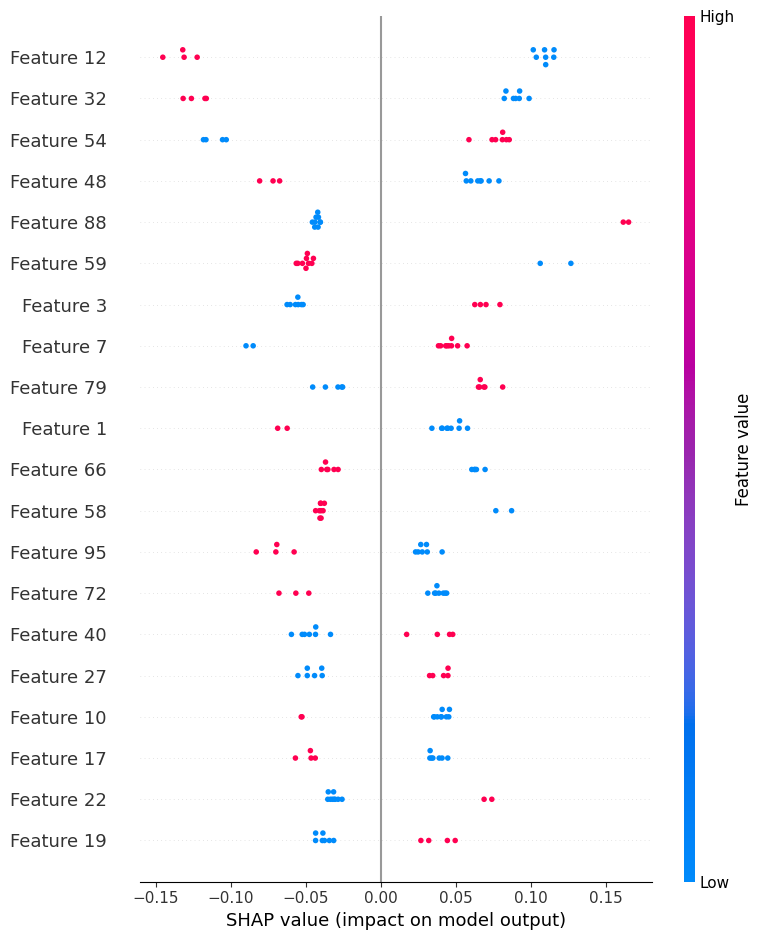

SHAP values for class 1:


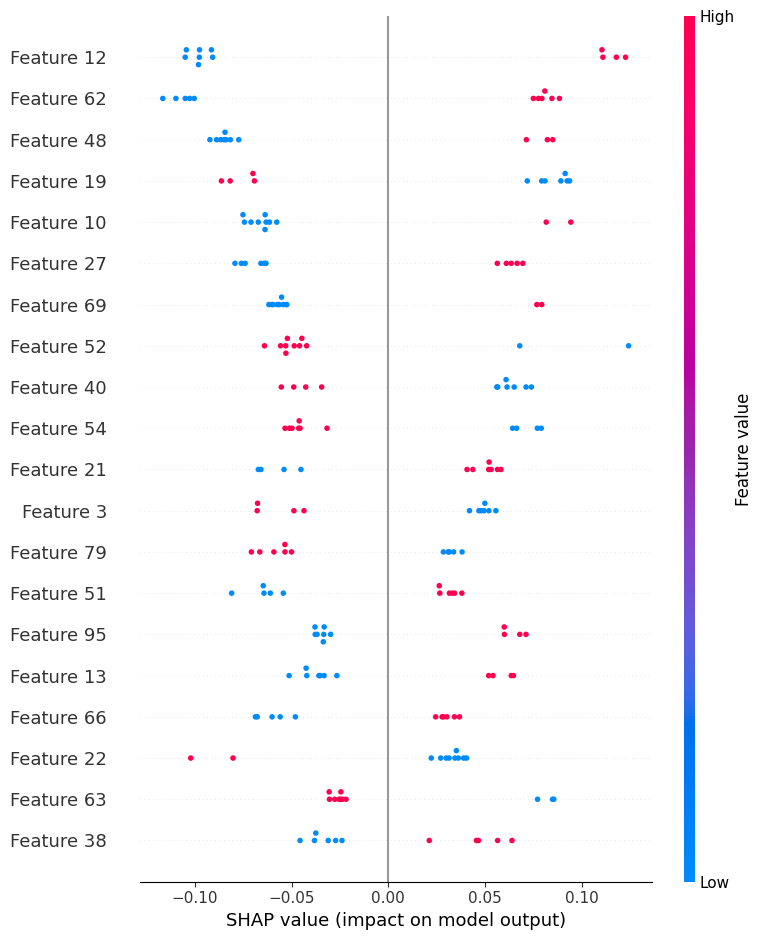

SHAP values for class 2:


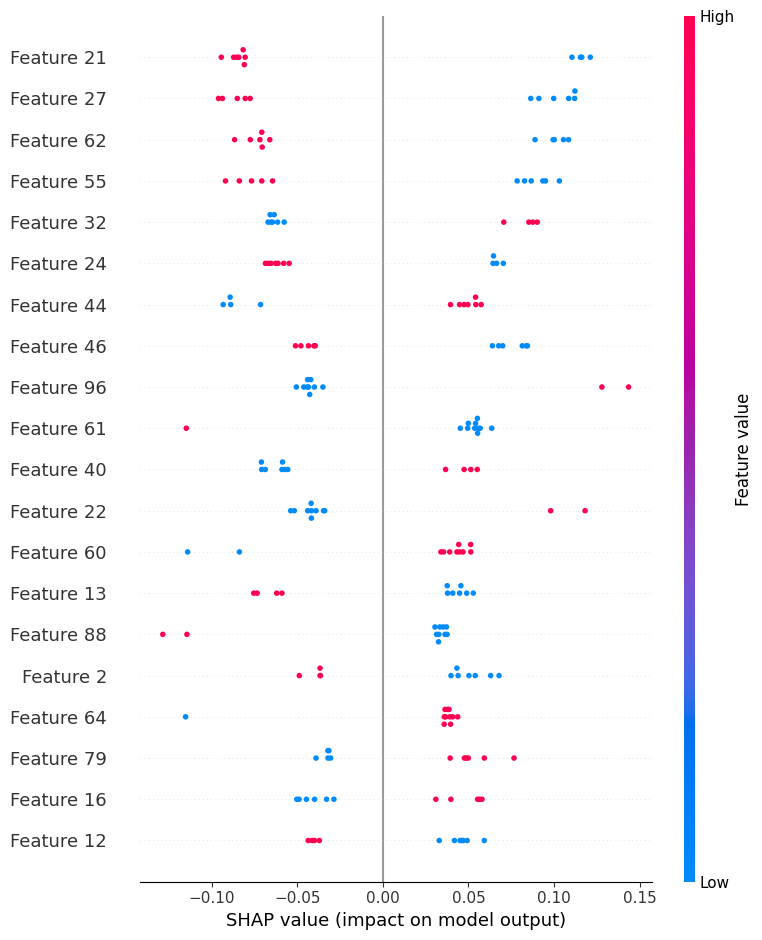

In [ ]:
# Check the shape of shap_values
print(f"shap_values.shape: {np.array(shap_values).shape}")

# Assuming shap_values has the shape (num_samples, num_features, num_classes)
num_classes = shap_values.shape[2]

# Iterate over each class and plot the SHAP values
for class_index in range(num_classes):
    print(f"SHAP values for class {class_index}:")
    shap_values_class = shap_values[:, :, class_index]
    shap.summary_plot(shap_values_class, X_test, feature_names=[f'Feature {i}' for i in range(input_size)])